In [14]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
#sns.set()

from pathlib import Path

from copy import deepcopy

In [2]:
TEXT_WIDTH = 6.18

In [142]:
sim_responses_carla_path = Path("../../data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/").resolve()
sim_responses_dsec_path = Path("../../data/experiments/dsec/on_off_cells/EMD/3_tiles/noise_level_0_0/").resolve()

raw_data_carla_path = Path("../../data/carla_sim/random_spawn/").resolve()
raw_data_dsec_path = Path("../../data/dsec/sequences/").resolve()
#sim_manual_rec_fold = "../../data/experiments/carla_sim/manual_recorded_scenes/"

# get all npz files in sim_responses_carla_path
samples_carla = list(sim_responses_carla_path.glob("*.npz"))
# get all npz files in sim_responses_dsec_fold
samples_dsec = list(sim_responses_dsec_path.glob("*.npz"))

In [54]:
samples_carla[0].stem

'example_0'

In [45]:
N_SAMPLES_DSEC = len(samples_dsec)

In [143]:
samples_carla_coll = []
for sample in samples_carla:
    metadata_path = raw_data_carla_path / sample.stem / "sim_data.npz"
    with np.load(metadata_path, allow_pickle=True) as data:
        coll_type = data["coll_type"][()]
        if coll_type not in ["none", "none_with_traffic", "none_with_crossing"]:
            samples_carla_coll.append(sample)

N_COLL_CARLA = len(samples_carla_coll)

if N_COLL_CARLA < N_SAMPLES_DSEC:
    samples_dsec = list(np.random.choice(samples_dsec, N_COLL_CARLA, replace=False))
    N_PER_CLASS = N_COLL_CARLA
    print("subsampling dsec")
elif N_COLL_CARLA > N_SAMPLES_DSEC:
    samples_carla_coll = list(np.random.choice(samples_carla_coll, N_SAMPLES_DSEC, replace=False))
    N_PER_CLASS = N_SAMPLES_DSEC
    print("subsampling carla")

print(f"# samples per class: {N_PER_CLASS}")

samples_merged = samples_carla_coll + samples_dsec

samples_metadata_carla = [raw_data_carla_path / sample.stem / "sim_data.npz" for sample in samples_carla_coll]
samples_metadata_dsec = [raw_data_dsec_path / sample.stem / "sim_data.npz" for sample in samples_dsec]

samples_metadata_merged = samples_metadata_carla + samples_metadata_dsec

N_TOTAL_SAMPLES = len(samples_merged)

subsampling carla
# samples per class: 134


In [144]:
samples_merged

[PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_460.npz'),
 PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_1026.npz'),
 PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_190.npz'),
 PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_1069.npz'),
 PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_1136.npz'),
 PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_1000.npz'),
 PosixPath('/media/fabian/My Passport/data_interneuron/data/experi

In [105]:
# get top-level folder
samples_metadata_merged[0]

PosixPath('/media/fabian/My Passport/data_interneuron/data/carla_sim/random_spawn/example_540/sim_data.npz')

In [106]:
samples_merged[0]

PosixPath('/media/fabian/My Passport/data_interneuron/data/experiments/carla_sim/random_spawn/on_off_cells/EMD/3_tiles/noise_level_0_0/example_540.npz')

In [145]:
df_metadata = pd.DataFrame(columns=["sample_id", "coll_type", "t_end", "vel", "diameter", "dt"])

for sample in samples_metadata_merged:
    smd = np.load(sample, allow_pickle=True)
    df_metadata = pd.concat(
        [
            df_metadata,
            pd.DataFrame(
                {
                    "sample_id": sample.parent.stem.split("_")[1],
                    "coll_type": [smd["coll_type"][()]],
                    "t_end": [smd["t_end"][()]],
                    "vel": [smd["vel"][()]],
                    "diameter": [smd["diameter_object"][()]],
                    "dt": [smd["dt"][()]],
                }
            ),
        ], ignore_index=True
    )

df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)

/tmp/ipykernel_772443/4152367255.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metadata = pd.concat(


In [146]:
df_metadata

,sample_id,coll_type,t_end,vel,diameter,dt
0,460,pedestrians,2289,5.301192,0.912731,10.0
1,1026,pedestrians,2160,9.638529,1.003315,10.0
2,190,pedestrians,2029,8.140621,0.853669,10.0
3,1069,pedestrians,2439,6.789059,0.897379,10.0
4,1136,cars,2209,2.906140,2.594586,10.0
...,...,...,...,...,...,...
263,37,none_with_traffic,4000.0,NaN,NaN,10.0
264,38,none_with_traffic,4000.0,NaN,NaN,10.0
265,39,none_with_traffic,4000.0,NaN,NaN,10.0
266,4,none_with_traffic,4000.0,NaN,NaN,10.0


In [147]:
df_metadata.coll_type.unique()

array(['pedestrians', 'cars', 'none_with_traffic'], dtype=object)

In [148]:
df_metadata["coll_type"].value_counts()

coll_type
none_with_traffic    134
cars                  71
pedestrians           63
Name: count, dtype: int64

In [149]:
model = "EMD"
ntile = 3
noise = 0.0

N_SUBSAMPLE = 2

tile_id_range_y = {3: (1, 1), 5: (1, 2, 3), 7: (2, 3, 4)}

noise_levels = [0.0]

df_responses = pd.DataFrame(
    columns=[
        "sample_id",
        "model",
        "n tiles",
        "tile_idx_y",
        "tile_idx_x",
        "coll_type",
        "coll_time",
        "vel",
        "diameter",
        "Output",
        "Output Linear",
        "r left",
        "r right",
        "time",
        "noise_rate",
    ]
)


for sample in samples_merged:
    try:
        sample_id = sample.stem.split("_")[1]
        sample_metadata = df_metadata[
            df_metadata["sample_id"] == sample_id
        ].iloc[0]
        try:
            smd = np.load(sample)
        except OSError as e:
            print(sample)

        time_ax = (
            np.arange(smd["v_out"].shape[2])
            - (sample_metadata["t_end"] / sample_metadata["dt"]).astype(int)
        ) * sample_metadata["dt"]
        output = smd["v_out"]

        output_linear = smd["v_out_linear"] * 2.0
        r_left = smd["r_left_out"]
        r_right = smd["r_right_out"]

        for idx_x in range(ntile):
            for idx_y in tile_id_range_y[ntile]:
                _resp = pd.DataFrame(
                            {
                                "sample_id": sample_id,
                                "model": model,
                                "n tiles": ntile,
                                "tile_idx_x": idx_x,
                                "tile_idx_y": idx_y,
                                "coll_type": sample_metadata["coll_type"],
                                "coll_time": sample_metadata["t_end"],
                                "vel": sample_metadata["vel"],
                                "diameter": sample_metadata["diameter"],
                                "Output": output[idx_y, idx_x],
                                "Output Linear": output_linear[
                                    idx_y, idx_x
                                ],
                                "r left": r_left[idx_y, idx_x],
                                "r right": r_right[idx_y, idx_x],
                                "time": time_ax,  # (((sample_metadata["dt"] * np.arange(smd["v_out"].shape[2]) - sample_metadata["t_end"]))/T_SUBSAMPLE).astype(int) * T_SUBSAMPLE,
                                "noise_rate": noise,
                            }
                        )
                
                df_responses = pd.concat(
                    [
                        df_responses,
                        _resp,
                    ],
                    ignore_index=True,
                )

    except OSError as e:
        print("could not find file")
        pass

time_ax = np.sort(df_responses["time"].unique())
time_ax_subsample = time_ax[::N_SUBSAMPLE]

df_responses = df_responses[df_responses["time"].isin(time_ax_subsample)]
df_responses = df_responses[df_responses["time"] <= 0.0]

/tmp/ipykernel_772443/2014616240.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_responses = pd.concat(


In [150]:
df_responses

,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,Output,Output Linear,r left,r right,time,noise_rate
0,460,EMD,3,1,0,pedestrians,2289,5.301192,0.912731,0.000000,0.000000,0.000000,0.000000,-2280.0,0.0
2,460,EMD,3,1,0,pedestrians,2289,5.301192,0.912731,0.000000,0.000000,0.000000,0.000000,-2260.0,0.0
4,460,EMD,3,1,0,pedestrians,2289,5.301192,0.912731,-0.217768,0.747661,-0.140288,0.514734,-2240.0,0.0
6,460,EMD,3,1,0,pedestrians,2289,5.301192,0.912731,-1.433667,0.625055,-1.345126,1.657218,-2220.0,0.0
8,460,EMD,3,1,0,pedestrians,2289,5.301192,0.912731,-0.456493,1.547545,-3.179814,3.954415,-2200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523712,40,EMD,3,1,2,none_with_traffic,4000.0,NaN,NaN,-0.104188,18.546715,-0.430766,9.534190,-100.0,0.0
523714,40,EMD,3,1,2,none_with_traffic,4000.0,NaN,NaN,-0.179042,19.535603,-0.282869,10.132952,-80.0,0.0
523716,40,EMD,3,1,2,none_with_traffic,4000.0,NaN,NaN,0.093196,20.841661,-0.042102,10.469299,-60.0,0.0
523718,40,EMD,3,1,2,none_with_traffic,4000.0,NaN,NaN,-0.152406,20.837444,-0.087404,10.431227,-40.0,0.0


In [151]:
df_responses["time"] = pd.to_numeric(df_responses["time"])
df_responses["n tiles"] = pd.to_numeric(df_responses["n tiles"])
df_responses["coll_time"] = pd.to_numeric(df_responses["coll_time"])
df_responses["Output"] = pd.to_numeric(df_responses["Output"]).astype(float)
df_responses["Output Linear"] = pd.to_numeric(df_responses["Output Linear"]).astype(
    float
)
df_responses["r left"] = pd.to_numeric(df_responses["r left"]).astype(float)
df_responses["r right"] = pd.to_numeric(df_responses["r right"]).astype(float)
df_responses["L/v"] = df_responses["diameter"] / df_responses["vel"]
df_responses["Collision Type"] = df_responses["coll_type"].map(
    {
        "none": "No Collision",
        "none_with_crossing": "No Collision",
        "none_with_traffic": "No Collision",
        "cars": "Cars",
        "pedestrians": "Pedestrians",
    }
)
#df_responses["min_stop_dist"] = df_responses["vel"] ** 2 / (2 * A_BREAK)
df_responses["dist"] = df_responses["vel"] * np.abs(df_responses["time"] / 1000)

In [152]:
df_responses.coll_type.unique()

array(['pedestrians', 'cars', 'none_with_traffic'], dtype=object)

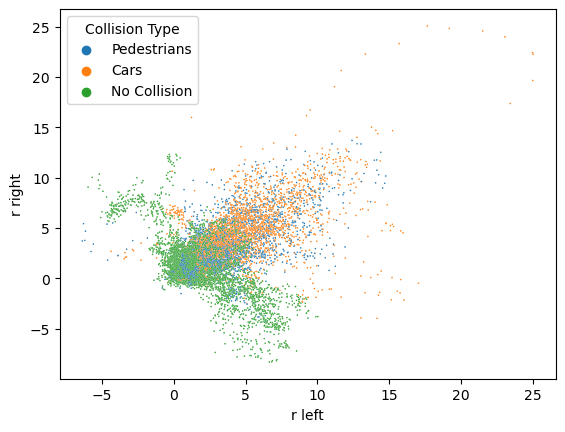

In [153]:
df_filt = df_responses[(df_responses["time"]>= -1000) & (df_responses["tile_idx_y"] == 1) & (df_responses["tile_idx_x"] == 1)]

sns.scatterplot(data=df_filt, x="r left", y="r right", hue="Collision Type", s=1)
plt.show()

In [154]:
df_responses.groupby(["coll_type"])["sample_id"].nunique()

coll_type
cars                  71
none_with_traffic    117
pedestrians           63
Name: sample_id, dtype: int64

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

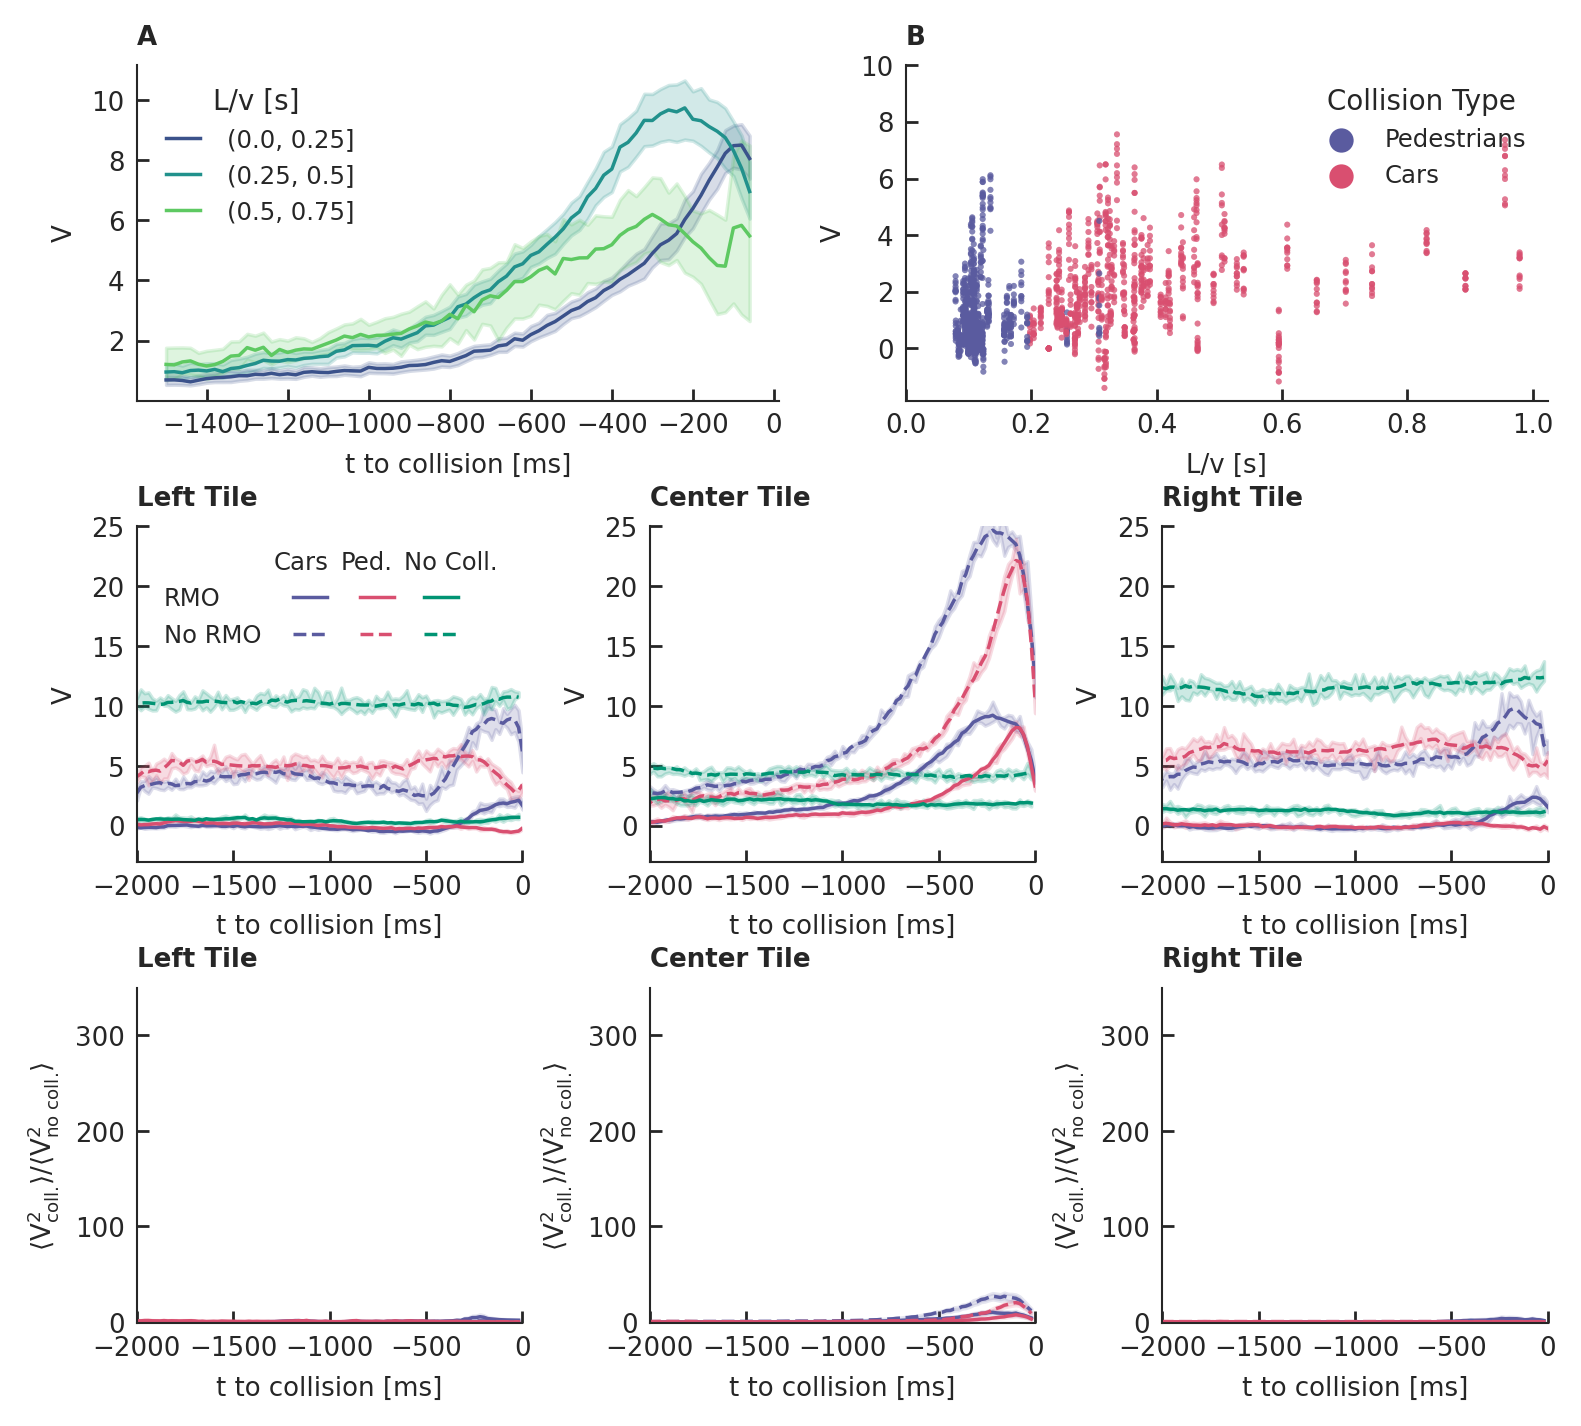

In [155]:
NOISE_RATE = 0.0

df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["noise_rate"] == NOISE_RATE)
]

plt.style.use("plots.mplstyle")

gs = plt.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1])

fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.9))

ax = [[], []]
ax[0].append(fig.add_subplot(gs[1, :2]))
ax[0].append(fig.add_subplot(gs[1, 2:4]))
ax[0].append(fig.add_subplot(gs[1, 4:]))

ax[1].append(fig.add_subplot(gs[2, :2]))
ax[1].append(fig.add_subplot(gs[2, 2:4]))
ax[1].append(fig.add_subplot(gs[2, 4:]))

ax = np.array(ax)

# fig, ax = plt.subplots(2, 3, figsize=(TEXT_WIDTH, TEXT_WIDTH*0.6))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import matplotlib.patches as m_patches

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]
patches_column4 = [m_patches.Patch(color="none", label="No Coll.")]

for k, _ax in enumerate(ax[0]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]

    _o_cars = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        label="*",
        legend=False,
    )

    _o_cars_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        linestyle="--",
        label="*",
        legend=False,
    )

    _o_pedestrians = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        label="*",
        legend=False,
    )

    _o_pedestrians_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "Pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        linestyle="--",
        label="*",
        legend=False,
    )

    _o_none = sns.lineplot(
        x="time",
        y="Output",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "No Collision"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        label="*",
        legend=False,
    )

    _o_none_linear = sns.lineplot(
        x="time",
        y="Output Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["Collision Type"] == "No Collision"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        linestyle="--",
        label="*",
        legend=False,
    )

    if k == 0:
        _lines = _ax.get_lines()
        patches_column2.extend([_lines[0], _lines[1]])
        patches_column3.extend([_lines[2], _lines[3]])
        patches_column4.extend([_lines[4], _lines[5]])

    _ax.set_ylabel("V")

    _ax.set_xlim(left=-2000, right=0.0)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=25.0, bottom=-3.0)

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)
patches.extend(patches_column4)

lg = ax[0, 0].legend(
    ncol=4,
    handles=patches,
    handletextpad=-2.5,
    borderpad=0.5,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8, 10, 11):
        text.set_color("none")

alpha_sem = 0.15

for k, _ax in enumerate(ax[1]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k)
        & (df_responses_filt["tile_idx_y"] == 1)
        & (df_responses_filt["time"] < 0.0)
    ].copy()

    _df_temp["Output Squ"] = _df_temp["Output"] * _df_temp["Output"]
    _df_temp["Output Linear Squ"] = (
        _df_temp["Output Linear"] * _df_temp["Output Linear"]
    )

    _power_resp = (
        _df_temp[["time", "Collision Type", "Output Squ", "Output Linear Squ"]]
        .groupby(["time", "Collision Type"])
        .mean()
        .reset_index()
    )
    _power_resp_sem = (
        _df_temp[["time", "Collision Type", "Output Squ", "Output Linear Squ"]]
        .groupby(["time", "Collision Type"])
        .sem()
        .reset_index()
    )

    _filt_cars = _power_resp["Collision Type"] == "Cars"
    _filt_pedestrians = _power_resp["Collision Type"] == "Pedestrians"
    _filt_none = _power_resp["Collision Type"] == "No Collision"

    _times_intersect = np.array(
        list(
            (
                set(_power_resp["time"][_filt_cars]).intersection(
                    set(_power_resp["time"][_filt_pedestrians])
                )
            ).intersection(set(_power_resp["time"][_filt_none]))
        )
    )

    _power_resp = _power_resp[_power_resp["time"].isin(_times_intersect)].copy()
    _power_resp_sem = _power_resp_sem[
        _power_resp_sem["time"].isin(_times_intersect)
    ].copy()

    _filt_cars = _power_resp["Collision Type"] == "Cars"
    _filt_pedestrians = _power_resp["Collision Type"] == "Pedestrians"
    _filt_none = _power_resp["Collision Type"] == "No Collision"

    _power_cars = np.array(list(_power_resp["Output Squ"][_filt_cars]))
    _power_cars_linear = np.array(list(_power_resp["Output Linear Squ"][_filt_cars]))
    _power_pedestrians = np.array(list(_power_resp["Output Squ"][_filt_pedestrians]))
    _power_pedestrians_linear = np.array(
        list(_power_resp["Output Linear Squ"][_filt_pedestrians])
    )
    _power_none = np.array(list(_power_resp["Output Squ"][_filt_none]))
    _power_none_linear = np.array(list(_power_resp["Output Linear Squ"][_filt_none]))

    _error_cars = np.array(list(_power_resp_sem["Output Squ"][_filt_cars]))
    _error_cars_linear = np.array(
        list(_power_resp_sem["Output Linear Squ"][_filt_cars])
    )
    _error_pedestrians = np.array(
        list(_power_resp_sem["Output Squ"][_filt_pedestrians])
    )
    _error_pedestrians_linear = np.array(
        list(_power_resp_sem["Output Linear Squ"][_filt_pedestrians])
    )
    _error_none = np.array(list(_power_resp_sem["Output Squ"][_filt_none]))
    _error_none_linear = np.array(
        list(_power_resp_sem["Output Linear Squ"][_filt_none])
    )

    _sign_to_noise_cars = _power_cars / _power_none
    _sign_to_noise_cars_linear = _power_cars_linear / _power_none_linear

    _sign_to_noise_pedestrians = _power_pedestrians / _power_none
    _sign_to_noise_pedestrians_linear = _power_pedestrians_linear / _power_none_linear

    # error propagation:
    # if A = B/C, then dA = sqrt((dB/B)^2 + (dC/C)^2) * A

    _error_sign_to_noise_cars = (
        np.sqrt((_error_cars / _power_cars) ** 2 + (_error_none / _power_none) ** 2)
        * _sign_to_noise_cars
    )

    _error_sign_to_noise_cars_linear = (
        np.sqrt(
            (_error_cars_linear / _power_cars_linear) ** 2
            + (_error_none_linear / _power_none_linear) ** 2
        )
        * _sign_to_noise_cars_linear
    )

    _error_sign_to_noise_pedestrians = (
        np.sqrt(
            (_error_pedestrians / _power_pedestrians) ** 2
            + (_error_none / _power_none) ** 2
        )
        * _sign_to_noise_pedestrians
    )

    _error_sign_to_noise_pedestrians_linear = (
        np.sqrt(
            (_error_pedestrians_linear / _power_pedestrians_linear) ** 2
            + (_error_none_linear / _power_none_linear) ** 2
        )
        * _sign_to_noise_pedestrians_linear
    )

    _times_intersect = np.sort(
        list(
            (
                set(_power_resp["time"][_filt_cars]).intersection(
                    set(_power_resp["time"][_filt_pedestrians])
                )
            ).intersection(set(_power_resp["time"][_filt_none]))
        )
    )

    _power_resp = _power_resp[_power_resp["time"].isin(_times_intersect)].copy()

    _filt_cars = _power_resp["Collision Type"] == "Cars"
    _filt_pedestrians = _power_resp["Collision Type"] == "Pedestrians"
    _filt_none = _power_resp["Collision Type"] == "No Collision"

    _ax.plot(_times_intersect, _sign_to_noise_cars, color=colors[0])
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_cars - _error_sign_to_noise_cars,
        _sign_to_noise_cars + _error_sign_to_noise_cars,
        color=colors[0],
        alpha=alpha_sem,
    )

    _ax.plot(
        _times_intersect, _sign_to_noise_cars_linear, color=colors[0], linestyle="--"
    )
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_cars_linear - _error_sign_to_noise_cars_linear,
        _sign_to_noise_cars_linear + _error_sign_to_noise_cars_linear,
        color=colors[0],
        alpha=alpha_sem,
    )

    _ax.plot(_times_intersect, _sign_to_noise_pedestrians, color=colors[1])
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_pedestrians - _error_sign_to_noise_pedestrians,
        _sign_to_noise_pedestrians + _error_sign_to_noise_pedestrians,
        color=colors[1],
        alpha=alpha_sem,
    )

    _ax.plot(
        _times_intersect,
        _sign_to_noise_pedestrians_linear,
        color=colors[1],
        linestyle="--",
    )
    _ax.fill_between(
        _times_intersect,
        _sign_to_noise_pedestrians_linear - _error_sign_to_noise_pedestrians_linear,
        _sign_to_noise_pedestrians_linear + _error_sign_to_noise_pedestrians_linear,
        color=colors[1],
        alpha=alpha_sem,
    )

    _ax.set_xlim(left=-2000, right=0.0)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=350.0, bottom=-1.0)

    _ax.set_ylabel(
        "$\\langle \\text{V}_{\\text{coll.}}^2\\rangle / \\langle \\text{V}_{\\text{no coll.}}^2\\rangle$"
    )

    # _ax.set_yscale("log")

ax[0, 0].set_title("Left Tile", loc="left")
ax[0, 1].set_title("Center Tile", loc="left")
ax[0, 2].set_title("Right Tile", loc="left")

ax[1, 0].set_title("Left Tile", loc="left")
ax[1, 1].set_title("Center Tile", loc="left")
ax[1, 2].set_title("Right Tile", loc="left")

#######################################

ax_lv_t = fig.add_subplot(gs[0, :3])
ax_lv_scatt = fig.add_subplot(gs[0, 3:])

df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["Collision Type"] != "No Collision")
].copy()

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -50)
]

_df_temp["L/v [s]"] = _df_temp["L/v"]

sns.lineplot(
    x="time",
    y="Output",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(
        _df_temp["L/v [s]"],
        bins=pd.IntervalIndex.from_tuples([(0.0, 0.25), (0.25, 0.5), (0.5, 0.75)]),
    ),
    palette="viridis",
    ax=ax_lv_t,
    n_boot=200,
)
# ax[0].set_xlim(left=-2000)
ax_lv_t.set_xlabel("t to collision [ms]")
ax_lv_t.set_ylabel("V")

sns.scatterplot(
    data=_df_temp[(_df_temp.time >= -1000) & (_df_temp.time <= -800)],
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x="L/v [s]",
    y="Output",
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    # sort=True,
    # orient="x",
    hue="Collision Type",
    # palette="viridis",
    ax=ax_lv_scatt,
    # n_boot=100,
    s=3,
    linewidth=0,
    alpha=0.5,
    rasterized=True,
)

ax_lv_scatt.set_ylabel("V")

ax_lv_scatt.set_ylim(top=10)
ax_lv_scatt.set_xlim(left=0.0)

ax_lv_t.set_title("A", loc="left")
ax_lv_scatt.set_title("B", loc="left")

fig.tight_layout(pad=0.25)

fig.savefig("responses_emd_3_tile_noisy.png", dpi=400)
fig.savefig("responses_emd_3_tile_noisy.pdf")

plt.show()

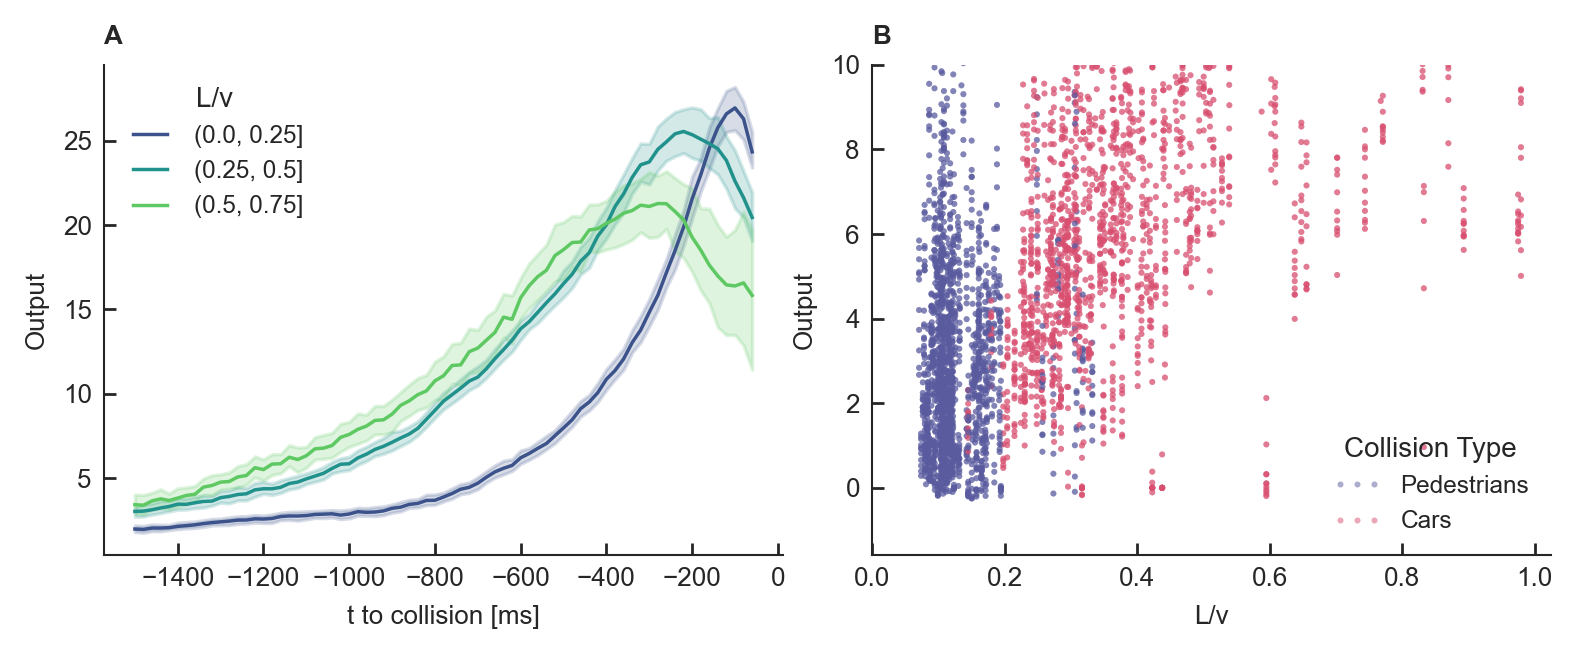

In [16]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["Collision Type"] != "No Collision")
]

fig, ax = plt.subplots(1, 2, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.4))

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -50)
]
sns.lineplot(
    x="time",
    y="Output",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(
        _df_temp["L/v"],
        bins=pd.IntervalIndex.from_tuples([(0.0, 0.25), (0.25, 0.5), (0.5, 0.75)]),
    ),
    palette="viridis",
    ax=ax[0],
    n_boot=200,
)
# ax[0].set_xlim(left=-2000)
ax[0].set_xlabel("t to collision [ms]")

sns.scatterplot(
    data=_df_temp[(_df_temp.time >= -1000) & (_df_temp.time <= -800)],
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x="L/v",
    y="Output",
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    # sort=True,
    # orient="x",
    hue="Collision Type",
    # palette="viridis",
    ax=ax[1],
    # n_boot=100,
    s=3,
    linewidth=0,
    alpha=0.5,
)

ax[1].set_ylim(top=10)
ax[1].set_xlim(left=0.0)

ax[0].set_title("A", loc="left")
ax[1].set_title("B", loc="left")

fig.tight_layout(pad=0.25)

fig.savefig("l_v_responses_emd_3_tile_noisy.png", dpi=400)
fig.savefig("l_v_responses_emd_3_tile_noisy.pdf")

plt.show()

### Functions to Calculate Performance Metrics with Safety Margins

In [156]:
def calc_min_react_time_sweep(df, n_sweep, t_max, t_window, noise_levels=[0.0], n_samples=10):

    base_dict = {
        f"noise_level_{noise}": {"RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},}
        for noise in noise_levels
    }

    roc = deepcopy(base_dict)
    aupr = deepcopy(base_dict)
    roc_curve_sweep = deepcopy(base_dict)
    pr_curve_sweep = deepcopy(base_dict)
    max_f1 = deepcopy(base_dict)

    df = df.copy()
    df["positive"] = df["Collision Type"] != "No Collision"

    min_reaction_time = np.linspace(0.0, t_max - t_window, n_sweep)

    for noise in noise_levels:

        noise_str = f"noise_level_{noise}"

        for rmo in ["RMO", "No RMO"]:
            for obj in ["Cars", "Pedestrians"]:
                print(f"Calculating {noise_str} {rmo} {obj}...")
                for i in range(n_samples):
                    print(f"Sample {i+1}/{n_samples}", end="\r")

                    roc[noise_str][rmo][obj].append([])
                    aupr[noise_str][rmo][obj].append([])
                    roc_curve_sweep[noise_str][rmo][obj].append([])
                    pr_curve_sweep[noise_str][rmo][obj].append([])
                    max_f1[noise_str][rmo][obj].append([])

                    for t in min_reaction_time:
                        t_no_coll_t0 = np.random.rand() * (t_max - t_window)
                        _df_filt = df[
                            ((
                                (
                                    (df["time"] <= -t)
                                    & (df["time"] >= -(t + t_window))
                                )
                                & (df["Collision Type"] == obj)
                            )
                            | (
                                (
                                    (df["time"] <= -t_no_coll_t0)
                                    & (df["time"] >= -(t_no_coll_t0 + t_window))
                                )
                                & (df["Collision Type"] == "No Collision")
                            )) & (df["noise_rate"] == noise)
                        ].copy()

                        df_max_resp = (
                            _df_filt.groupby(["sample_id", "positive"]).max().reset_index()
                        )

                        min_class_samples = df_max_resp["positive"].value_counts().min()
                        df_max_resp = (
                            df_max_resp.groupby("positive", as_index=False)[
                                [
                                    "positive",
                                    "Output" if (rmo == "RMO") else "Output Linear",
                                ]
                            ]
                            .apply(lambda x: x.sample(n=min_class_samples))
                            .reset_index(drop=True)
                        )

                        if rmo == "No RMO":
                            df_max_resp["Output"] = df_max_resp["Output Linear"]

                        roc[noise_str][rmo][obj][-1].append(
                            roc_auc_score(df_max_resp["positive"], df_max_resp["Output"])
                        )
                        aupr[noise_str][rmo][obj][-1].append(
                            average_precision_score(
                                df_max_resp["positive"], df_max_resp["Output"]
                            )
                        )
                        roc_curve_sweep[noise_str][rmo][obj][-1].append(
                            roc_curve(df_max_resp["positive"], df_max_resp["Output"])
                        )

                        pr_curve_sweep[noise_str][rmo][obj][-1].append(
                            precision_recall_curve(
                                df_max_resp["positive"], df_max_resp["Output"]
                            )
                        )

                        num = 2 * pr_curve_sweep[noise_str][rmo][obj][-1][-1][0] * pr_curve_sweep[noise_str][rmo][obj][-1][-1][1]
                        denom = pr_curve_sweep[noise_str][rmo][obj][-1][-1][0] + pr_curve_sweep[noise_str][rmo][obj][-1][-1][1]
                        max_f1[noise_str][rmo][obj][-1].append(
                            np.divide(num, denom, out=np.zeros_like(denom), where=(denom != 0)).max()
                        )
                
                roc[noise_str][rmo][obj] = np.array(roc[noise_str][rmo][obj])
                aupr[noise_str][rmo][obj] = np.array(aupr[noise_str][rmo][obj])
                #roc_curve_sweep[rmo][obj] = np.array(roc_curve_sweep[rmo][obj])
                #pr_curve_sweep[rmo][obj] = np.array(pr_curve_sweep[rmo][obj])
                max_f1[noise_str][rmo][obj] = np.array(max_f1[noise_str][rmo][obj])
    
    return min_reaction_time, roc, aupr, roc_curve_sweep, pr_curve_sweep, max_f1

In [157]:
def calc_min_velocity_sweep(
    df,
    n_sweep,
    vel_min_kmh,
    vel_max_kmh,
    a_break_mpssq,
    t_max=2000.0,
    t_window=200.0,
    noise_levels=[0.0],
    n_samples=10,
):
    base_dict = {
        f"noise_level_{noise}": {"RMO": {"Cars": [], "Pedestrians": []},
        "No RMO": {"Cars": [], "Pedestrians": []},}
        for noise in noise_levels
    }

    roc = deepcopy(base_dict)
    aupr = deepcopy(base_dict)
    roc_curve_sweep = deepcopy(base_dict)
    pr_curve_sweep = deepcopy(base_dict)
    max_f1 = deepcopy(base_dict)

    df = df.copy()
    df["positive"] = df["Collision Type"] != "No Collision"

    df["min_stop_dist"] = df["vel"] ** 2 / (2 * a_break_mpssq)
    df["min_stop_time"] = (df["vel"] / (2 * a_break_mpssq)) * 1000.0

    vel = np.linspace(vel_min_kmh / 3.6, vel_max_kmh / 3.6, n_sweep + 1)

    for noise in noise_levels:

        noise_str = f"noise_level_{noise}"

        for rmo in ["RMO", "No RMO"]:
            for obj in ["Cars", "Pedestrians"]:
                print(f"Calculating {noise_str} {rmo} {obj}...")
                for i in range(n_samples):
                    print(f"Sample {i+1}/{n_samples}", end="\r")
                    roc[noise_str][rmo][obj].append([])
                    aupr[noise_str][rmo][obj].append([])
                    roc_curve_sweep[noise_str][rmo][obj].append([])
                    pr_curve_sweep[noise_str][rmo][obj].append([])
                    max_f1[noise_str][rmo][obj].append([])

                    for j in range(len(vel) - 1):
                        v0 = vel[j]
                        v1 = vel[j + 1]

                        t_no_coll_t0 = np.random.rand() * (t_max - t_window)
                        _df_filt = df[
                            ((
                                ((df["vel"] >= v0) & (df["vel"] < v1))
                                & (
                                    (df["time"] <= -df["min_stop_time"])
                                    & (df["time"] >= -(df["min_stop_time"] + t_window))
                                )
                                &
                                (df["Collision Type"] == obj)
                            )
                            | (
                                (
                                    (df["time"] <= -t_no_coll_t0)
                                    & (df["time"] >= -(t_no_coll_t0 + t_window))
                                )
                                & (df["Collision Type"] == "No Collision")
                            )) & (df["noise_rate"] == noise)
                        ].copy()

                        df_max_resp = (
                            _df_filt.groupby(["sample_id", "positive"]).max().reset_index()
                        )

                        min_class_samples = df_max_resp["positive"].value_counts().min()
                        df_max_resp = (
                            df_max_resp.groupby("positive", as_index=False)[
                                [
                                    "positive",
                                    "Output" if (rmo == "RMO") else "Output Linear",
                                ]
                            ]
                            .apply(lambda x: x.sample(n=min_class_samples))
                            .reset_index(drop=True)
                        )

                        if rmo == "No RMO":
                            df_max_resp["Output"] = df_max_resp["Output Linear"]

                        roc[noise_str][rmo][obj][-1].append(
                            roc_auc_score(df_max_resp["positive"], df_max_resp["Output"])
                        )
                        aupr[noise_str][rmo][obj][-1].append(
                            average_precision_score(
                                df_max_resp["positive"], df_max_resp["Output"]
                            )
                        )
                        roc_curve_sweep[noise_str][rmo][obj][-1].append(
                            roc_curve(df_max_resp["positive"], df_max_resp["Output"])
                        )

                        pr_curve_sweep[noise_str][rmo][obj][-1].append(
                            precision_recall_curve(
                                df_max_resp["positive"], df_max_resp["Output"]
                            )
                        )

                        num = (
                            2
                            * pr_curve_sweep[noise_str][rmo][obj][-1][-1][0]
                            * pr_curve_sweep[noise_str][rmo][obj][-1][-1][1]
                        )
                        denom = (
                            pr_curve_sweep[noise_str][rmo][obj][-1][-1][0]
                            + pr_curve_sweep[noise_str][rmo][obj][-1][-1][1]
                        )
                        max_f1[noise_str][rmo][obj][-1].append(
                            np.divide(
                                num, denom, out=np.zeros_like(denom), where=(denom != 0)
                            ).max()
                        )

                roc[noise_str][rmo][obj] = np.array(roc[noise_str][rmo][obj])
                aupr[noise_str][rmo][obj] = np.array(aupr[noise_str][rmo][obj])
                # roc_curve_sweep[rmo][obj] = np.array(roc_curve_sweep[rmo][obj])
                # pr_curve_sweep[rmo][obj] = np.array(pr_curve_sweep[rmo][obj])
                max_f1[noise_str][rmo][obj] = np.array(max_f1[noise_str][rmo][obj])

    return (
        vel,
        roc,
        aupr,
        roc_curve_sweep,
        pr_curve_sweep,
        max_f1,
    )

In [158]:
min_reaction_time, roc, aupr, roc_curve_sweep, pr_curve_sweep, max_f1 = (
    calc_min_react_time_sweep(
        df_responses[
            (df_responses["model"] == "EMD")
            & (df_responses["n tiles"] == 3)
            & (df_responses["tile_idx_y"] == 1)
        ],
        20,
        2000,
        200,
        n_samples=50,
        noise_levels=noise_levels,
    )
)

Calculating noise_level_0.0 RMO Cars...
Calculating noise_level_0.0 RMO Pedestrians...
Calculating noise_level_0.0 No RMO Cars...
Calculating noise_level_0.0 No RMO Pedestrians...


In [159]:
np.savez(
    "min_reaction_time_sweep_emd.npz",
    min_reaction_time=min_reaction_time,
    roc=roc,
    aupr=aupr,
    roc_curve_sweep=roc_curve_sweep,
    pr_curve_sweep=pr_curve_sweep,
    max_f1=max_f1,
)

In [160]:
A_BREAK = 7.5

vel, roc_vel, aupr_vel, roc_curve_sweep_vel, pr_curve_sweep_vel, max_f1_vel = calc_min_velocity_sweep(
    df_responses[
        (df_responses["model"] == "EMD")
        & (df_responses["n tiles"] == 3)
        & (df_responses["tile_idx_y"] == 1)
    ],
    3,
    10.0,
    40.0,
    A_BREAK,
    t_max=2000.0,
    t_window=200.0,
    n_samples=50,
    noise_levels=noise_levels,
)

Calculating noise_level_0.0 RMO Cars...
Calculating noise_level_0.0 RMO Pedestrians...
Calculating noise_level_0.0 No RMO Cars...
Calculating noise_level_0.0 No RMO Pedestrians...


In [161]:
np.savez(
    "min_velocity_sweep_emd.npz",
    vel=vel,
    roc=roc_vel,
    aupr=aupr_vel,
    roc_curve_sweep=roc_curve_sweep_vel,
    pr_curve_sweep=pr_curve_sweep_vel,
    max_f1=max_f1_vel,
)

In [162]:
df_vel_roc = pd.DataFrame(columns=["vel", "roc", "roc_sem", "model", "Collision Type", "noise_rate"])

for i, v in enumerate(vel[:-1]):
    for noise in noise_levels:
        noise_str = f"noise_level_{noise}"
        for rmo in ["RMO", "No RMO"]:
            for obj in ["Cars", "Pedestrians"]:
                df_vel_roc = pd.concat(
                    [
                        df_vel_roc,
                        pd.DataFrame(
                            {
                                "vel": v * 3.6,
                                "roc": roc_vel[noise_str][rmo][obj][:, i].mean(),
                                "roc_sem": roc_vel[noise_str][rmo][obj][:, i].std(),
                                "model": rmo,
                                "Collision Type": obj,
                                "noise_rate": noise,
                            },
                            index=[0],
                        ),
                    ],
                    ignore_index=True,
                )

/tmp/ipykernel_772443/1217808755.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_vel_roc = pd.concat(


In [163]:
df_vel_roc

,vel,roc,roc_sem,model,Collision Type,noise_rate
0,10.0,0.838343,0.090449,RMO,Cars,0.0
1,10.0,0.776250,0.117112,RMO,Pedestrians,0.0
2,10.0,0.772663,0.067560,No RMO,Cars,0.0
3,10.0,0.594063,0.101382,No RMO,Pedestrians,0.0
4,20.0,0.773981,0.048549,RMO,Cars,0.0
5,20.0,0.458387,0.053828,RMO,Pedestrians,0.0
6,20.0,0.626983,0.046973,No RMO,Cars,0.0
7,20.0,0.342475,0.035084,No RMO,Pedestrians,0.0
8,30.0,0.604444,0.074338,RMO,Cars,0.0
9,30.0,0.346154,0.099677,RMO,Pedestrians,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

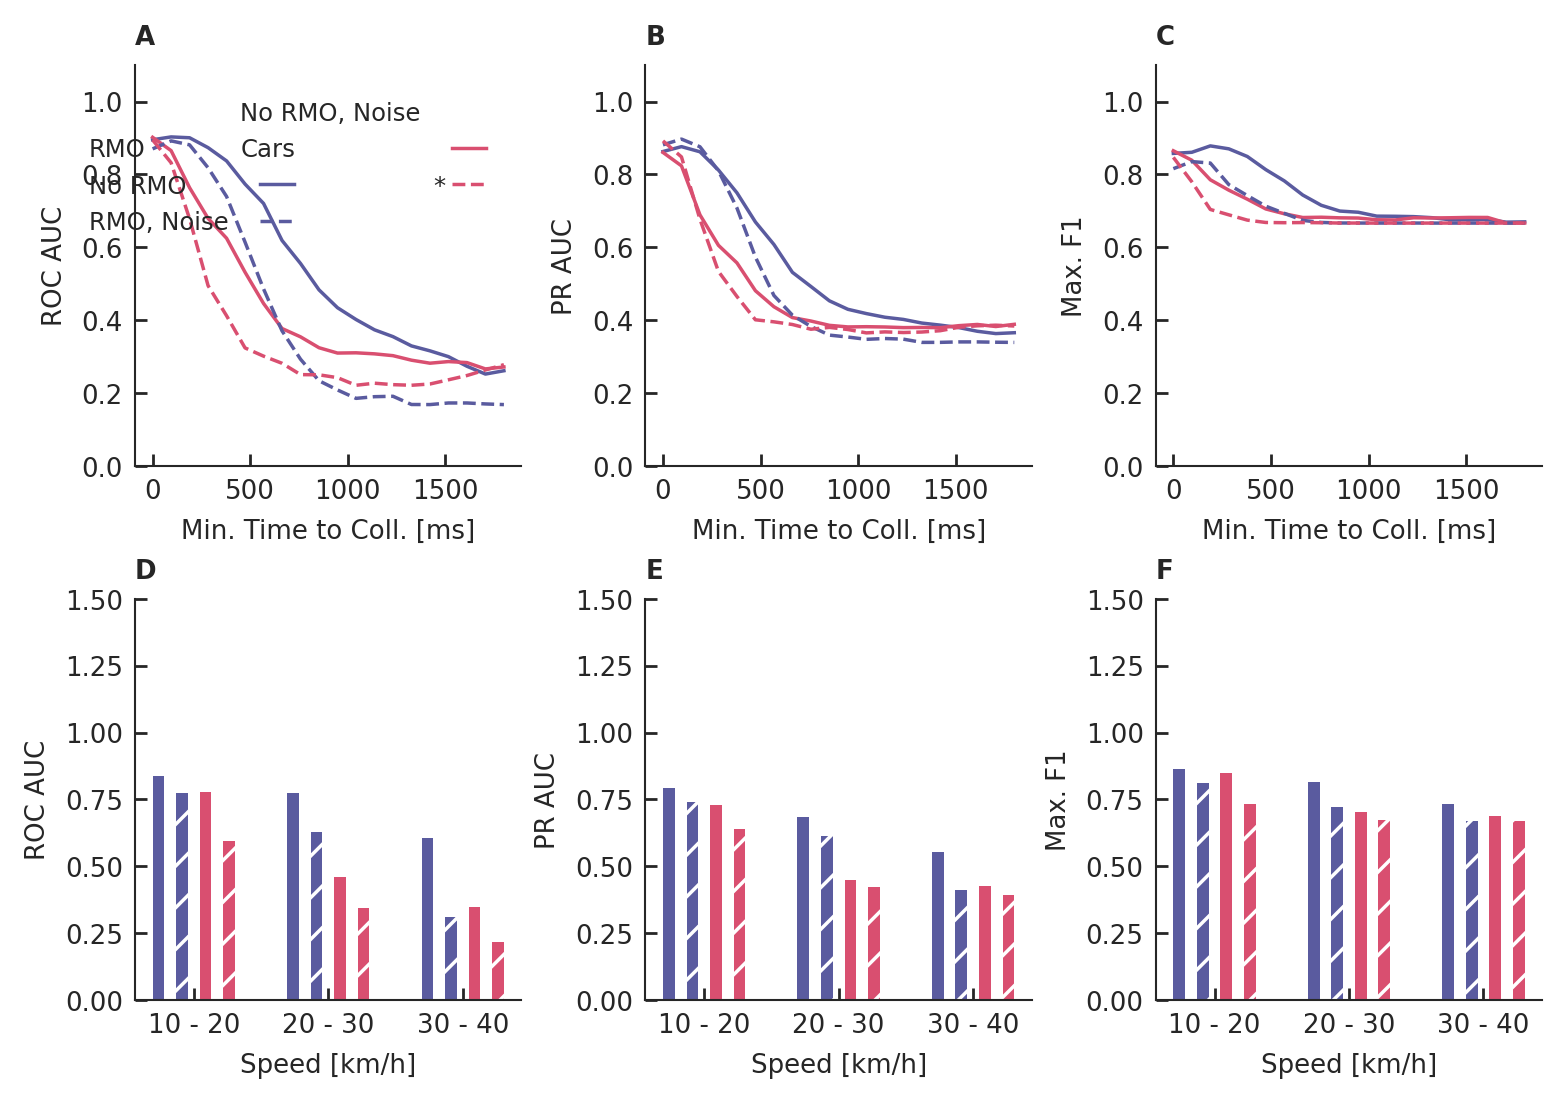

In [166]:
import matplotlib.patches as m_patches



patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
    m_patches.Patch(color="none", label="RMO, Noise"),
    m_patches.Patch(color="none", label="No RMO, Noise"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

plt.style.use('plots.mplstyle')

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(2, 3, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.7))

ptch = [patches_column2, patches_column3]

for noise in [0.0]:
    noise_str = f"noise_level_{noise}"
    alpha_scale = 1.# - 0.5 * noise / noise_levels[-1]
    for i, rmo in enumerate(["RMO", "No RMO"]):
        for j, obj in enumerate(["Cars", "Pedestrians"]):
            lnstyle = ["-", "--"][i]# if noise == 0.0 else ["-o", "--o"][i]
            color = colors[j] if noise == 0.0 else colors[j+2]
            #print(color)

            (_roc,) = ax[0,0].plot(
                min_reaction_time,
                roc[noise_str][rmo][obj].mean(axis=0),
                lnstyle,
                c=color,
                alpha=alpha_scale,
                label="*",
            )

            ptch[j].append(_roc)

            ax[0,1].plot(
                min_reaction_time, aupr[noise_str][rmo][obj].mean(axis=0), lnstyle, c=color, alpha=alpha_scale, label="*"
            )

            ax[0,2].plot(
                min_reaction_time, max_f1[noise_str][rmo][obj].mean(axis=0), lnstyle, c=color, alpha=alpha_scale, label="*"
            )

            """
            for k, metric in enumerate([roc, aupr, max_f1]):
                ax[0,k].fill_between(
                    min_reaction_time,
                    metric[noise_str][rmo][obj].mean(axis=0)
                    - metric[noise_str][rmo][obj].std(axis=0) / np.sqrt(1 + metric[noise_str][rmo][obj].shape[0]),
                    metric[noise_str][rmo][obj].mean(axis=0)
                    + metric[noise_str][rmo][obj].std(axis=0) / np.sqrt(1 + metric[noise_str][rmo][obj].shape[0]),
                    alpha=0.2 * alpha_scale,
                    color=color,
                )
            """


patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

lg = ax[0,0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, letter in enumerate(["A", "B", "C"]):
    ax[0,i].set_ylim(top=1.1, bottom=0.0)
    ax[0,i].set_xlabel("Min. Time to Coll. [ms]")
    ax[0,i].set_title(letter, loc="left", fontweight="bold")

ax[0,0].set_ylabel("ROC AUC")
ax[0,1].set_ylabel("PR AUC")
ax[0,2].set_ylabel("Max. F1")

for i, text in enumerate(lg.get_texts()):
    if i in (6, 7, 8, 9, 11, 12, 13, 14):
        text.set_color("none")

#####################################################

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Cars+Ns.")]
patches_column4 = [m_patches.Patch(color="none", label="Ped.")]
patches_column5 = [m_patches.Patch(color="none", label="Ped.+Ns.")]


vel_ax = 0.5 * (vel[:-1] + vel[1:]) * 3.6

d_vel = (vel[1:] - vel[:-1]) * 3.6
perc_width = 0.7

ptch = [patches_column2, patches_column3, patches_column4, patches_column5]
for k, noise in enumerate([0.0]):
    noise_str = f"noise_level_{noise}"
    for i, rmo in enumerate(["RMO", "No RMO"]):
        for j, obj in enumerate(["Cars", "Pedestrians"]):
            hatchstyle = [None, "//"][i]
            alpha = 1.0#[1.0, 0.5][i]
            color = colors[j] if noise == 0.0 else colors[j+2]

            barcontainer = ax[1,0].bar(
                vel_ax + (0.25 * k + 0.5 * i + j - 0.75) * d_vel * perc_width / 2,
                roc_vel[noise_str][rmo][obj].mean(axis=0),
                d_vel * perc_width / 8,
                color=color,
                label="*",
                hatch=hatchstyle,
                linewidth=0.5,
                alpha=alpha,
            )

            for bc in barcontainer:
                bc._hatch_color = (1, 1, 1)
                bc.stale = True

            ptch[j*2+k].append(barcontainer)

            barcontainer = ax[1,1].bar(
                vel_ax + (0.25 * k + 0.5 * i + j - 0.75) * d_vel * perc_width / 2,
                aupr_vel[noise_str][rmo][obj].mean(axis=0),
                d_vel * perc_width / 8,
                color=color,
                label="*",
                hatch=hatchstyle,
                linewidth=0.5,
                alpha=alpha,
            )

            for bc in barcontainer:
                bc._hatch_color = (1, 1, 1)
                bc.stale = True

            barcontainer = ax[1,2].bar(
                vel_ax + (0.25 * k + 0.5 * i + j - 0.75) * d_vel * perc_width / 2,
                max_f1_vel[noise_str][rmo][obj].mean(axis=0),
                d_vel * perc_width / 8,
                color=color,
                label="*",
                hatch=hatchstyle,
                linewidth=0.5,
                alpha=alpha,
            )

            for bc in barcontainer:
                bc._hatch_color = (1, 1, 1)
                bc.stale = True

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)
patches.extend(patches_column4)
patches.extend(patches_column5)

xticks = [f"{vel[i]*3.6:.0f} - {vel[i+1]*3.6:.0f}" for i in range(len(vel) - 1)]

for i, letter in enumerate(["D", "E", "F"]):
    ax[1,i].set_ylim(top=1.5, bottom=0.0)
    ax[1,i].set_xticks(vel_ax, xticks)
    ax[1,i].set_xlabel("Speed [km/h]")
    ax[1,i].set_title(letter, loc="left", fontweight="bold")

ax[1,0].set_ylabel("ROC AUC")
ax[1,1].set_ylabel("PR AUC")
ax[1,2].set_ylabel("Max. F1")


"""
lg = ax[1,0].legend(
    ncol=5,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8, 10, 11, 13, 14):
        text.set_color("none")
"""

fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd_ttc_speed_noisy.png", dpi=400)
fig.savefig("score_comp_emd_ttc_speed_noisy.pdf")
plt.show()

In [31]:
ind_t = 14

min_reaction_time[ind_t]

1326.3157894736844

In [77]:
roc_df = pd.DataFrame(
    {
        "RMO": {
            "Cars": roc["RMO"]["Cars"].mean(axis=0)[ind_t],
            "Pedestrians": roc["RMO"]["Pedestrians"].mean(axis=0)[ind_t],
        },
        "RMO Error": {
            "Cars": roc["RMO"]["Cars"].std(axis=0)[ind_t] / np.sqrt(1 + roc["RMO"]["Cars"].shape[0]),
            "Pedestrians": roc["RMO"]["Pedestrians"].std(axis=0)[ind_t] / np.sqrt(1 + roc["RMO"]["Pedestrians"].shape[0]),
        },
        "No RMO": {
            "Cars": roc["No RMO"]["Cars"].mean(axis=0)[ind_t],
            "Pedestrians": roc["No RMO"]["Pedestrians"].mean(axis=0)[ind_t],
        },
        "No RMO Error": {
            "Cars": roc["No RMO"]["Cars"].std(axis=0)[ind_t] / np.sqrt(1 + roc["No RMO"]["Cars"].shape[0]),
            "Pedestrians": roc["No RMO"]["Pedestrians"].std(axis=0)[ind_t] / np.sqrt(1 + roc["No RMO"]["Pedestrians"].shape[0]),
        },
    }
)

print(roc_df)
print(f"\nReaction Time: {min_reaction_time[ind_t]} ms")

                  RMO  RMO Error    No RMO  No RMO Error
Cars         0.912722   0.001606  0.741394      0.013161
Pedestrians  0.856411   0.002441  0.720593      0.013188

Reaction Time: 1326.3157894736844 ms


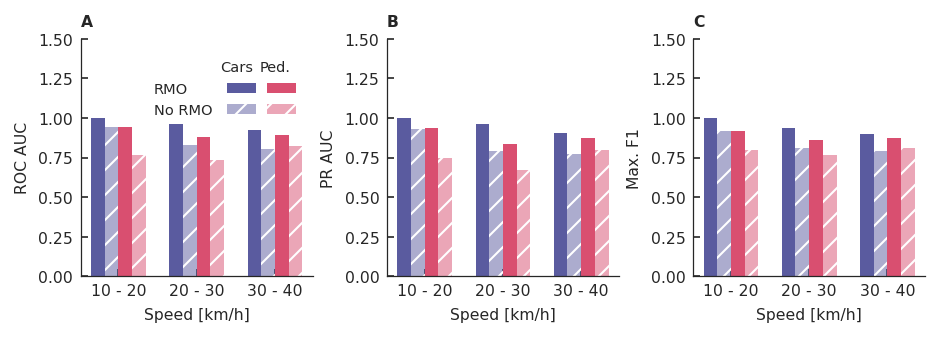

Assumed deceleration: 7.5 m/s^2


In [40]:
import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

plt.style.use("plots.mplstyle")
fig, ax = plt.subplots(1, 3, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.35))

vel_ax = 0.5 * (vel[:-1] + vel[1:]) * 3.6

d_vel = (vel[1:] - vel[:-1]) * 3.6
perc_width = 0.7


ptch = [patches_column2, patches_column3]

for i, rmo in enumerate(["RMO", "No RMO"]):
    for j, obj in enumerate(["Cars", "Pedestrians"]):
        hatchstyle = [None, "//"][i]
        alpha = [1.0, 0.5][i]
        color = colors[j]

        barcontainer = ax[0].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            roc_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

        ptch[j].append(barcontainer)

        barcontainer = ax[1].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            aupr_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

        barcontainer = ax[2].bar(
            vel_ax + (0.5 * i + j - 0.75) * d_vel * perc_width / 2,
            max_f1_vel[rmo][obj].mean(axis=0),
            d_vel * perc_width / 4,
            color=colors[j],
            label="*",
            hatch=hatchstyle,
            linewidth=0.5,
            alpha=alpha,
        )

        for bc in barcontainer:
            bc._hatch_color = (1, 1, 1)
            bc.stale = True

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

xticks = [f"{vel[i]*3.6:.0f} - {vel[i+1]*3.6:.0f}" for i in range(len(vel) - 1)]

for i, letter in enumerate(["A", "B", "C"]):
    ax[i].set_ylim(top=1.5, bottom=0.0)
    ax[i].set_xticks(vel_ax, xticks)
    ax[i].set_xlabel("Speed [km/h]")
    ax[i].set_title(letter, loc="left", fontweight="bold")

ax[0].set_ylabel("ROC AUC")
ax[1].set_ylabel("PR AUC")
ax[2].set_ylabel("Max. F1")


lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd_speeds.png", dpi=400)
fig.savefig("score_comp_emd_speeds.pdf")
plt.show()

print(f"Assumed deceleration: {A_BREAK} m/s^2")

The above figure shows the performance measures for different driving speeds under the condition that the detection should be before the minimal stopping distance for the given speed.

Under constant deceleration $a$, the minimum stopping distance is $d = v^2 / (2 a)$.

Some references for deceleration values:

+ https://www.sae.org/publications/technical-papers/content/2023-01-0616/
+ https://www.tandfonline.com/doi/pdf/10.1080/16484142.2007.9638118

### Calculate Mean Reaction Time Stats

In [17]:
def calc_react_time_stats(df, t_max, n_bootstrap=50):
    df = df.copy()

    df["positive"] = df["Collision Type"] != "No Collision"

    f1_mean = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    f1_sem = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    mean_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    sem_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    std_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    se_std_t_detect = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    th_range = {
        "RMO": {"Cars": None, "Pedestrians": None},
        "No RMO": {"Cars": None, "Pedestrians": None},
    }

    for rmo in ["RMO", "No RMO"]:
        for obj in ["Cars", "Pedestrians"]:
            print(f"Calculating {rmo} {obj}...")

            df_filt = df[
                ((df["time"] <= 0) & (df["time"] > -t_max))
                & (
                    (df["Collision Type"] == obj)
                    | (df["Collision Type"] == "No Collision")
                )
            ].copy()

            if rmo == "No RMO":
                df_filt["Output"] = df_filt["Output Linear"]

            df_max_resp = df_filt.groupby(["sample_id", "positive"]).max().reset_index()

            pr = precision_recall_curve(df_max_resp["positive"], df_max_resp["Output"])

            _f1 = []

            _f1.append(2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]))

            th_range[rmo][obj] = pr[2]

            n_samples = len(df_max_resp["positive"])

            for i in range(1, n_bootstrap):
                print(f"Bootstrap {i+1}/{n_bootstrap}", end="\r")
                ids = np.random.choice(n_samples, n_samples, replace=True)

                labels = df_max_resp["positive"].values[ids]
                scores = df_max_resp["Output"].values[ids]

                # we need to compute the precision and recall at the same thresholds
                # for the bootstrap samples
                pred = th_range[rmo][obj][:, np.newaxis] < scores[np.newaxis, :]
                tp = np.sum(pred & labels, axis=1)
                fp = np.sum(pred & ~labels, axis=1)

                precision = tp / (tp + fp)
                recall = tp / np.sum(labels)

                _f1.append(2 * precision * recall / (precision + recall))

            _f1 = np.array(_f1)
            f1_mean[rmo][obj] = np.mean(_f1, axis=0)
            f1_sem[rmo][obj] = np.std(_f1, axis=0)# / np.sqrt(n_bootstrap)

            df_th = pd.DataFrame(
                columns=[
                    "sample_id",
                    "Collision Type",
                    "Reaction Time [ms]",
                    "threshold",
                ]
            )

            for th in pr[2]:
                print(f"Threshold: {th}", end="\r")
                df_filt_th = df_filt[
                    (df_filt["Output"] >= th) & (df_filt["Collision Type"] == obj)
                ]
                df_first_detect = (
                    df_filt_th.groupby(["sample_id", "Collision Type"])
                    .min()
                    .reset_index()
                )
                df_th = pd.concat(
                    [
                        df_th,
                        pd.DataFrame(
                            {
                                "sample_id": df_first_detect["sample_id"],
                                "Collision Type": obj,
                                "Detect. Time to Coll. [ms]": -df_first_detect["time"],
                                "threshold": th,
                            }
                        ),
                    ],
                    ignore_index=True,
                )

            mean_t_detect[rmo][obj] = (
                df_th.groupby("threshold")["Detect. Time to Coll. [ms]"]
                .mean()
                .reset_index()["Detect. Time to Coll. [ms]"]
            )

            sem_t_detect[rmo][obj] = (
                df_th.groupby("threshold")["Detect. Time to Coll. [ms]"]
                .sem()
                .reset_index()["Detect. Time to Coll. [ms]"]
            )

            std_t_detect[rmo][obj] = (
                df_th.groupby("threshold")["Detect. Time to Coll. [ms]"]
                .std()
                .reset_index()["Detect. Time to Coll. [ms]"]
            )

            _std = []

            for i in range(n_bootstrap):
                _std_sample = df_th.groupby("threshold")["Detect. Time to Coll. [ms]"].apply(
                    lambda x: x.sample(n=x.shape[0], replace=True).std()
                ).reset_index()["Detect. Time to Coll. [ms]"]
                _std.append(_std_sample)
            
            _std = np.array(_std)

            se_std_t_detect[rmo][obj] = np.std(_std, axis=0)

    return th_range, f1_mean, f1_sem, mean_t_detect, sem_t_detect ,std_t_detect, se_std_t_detect


In [18]:
th_range, f1_mean, f1_sem, mean_t_detect, sem_t_detect, std_t_detect, se_std_t_detect = calc_react_time_stats(
    df_responses[
        (df_responses["model"] == "EMD")
        & (df_responses["n tiles"] == 3)
        & (df_responses["tile_idx_y"] == 1)
    ],
    2000.0,
    n_bootstrap=50,
)

Calculating RMO Cars...


/tmp/ipykernel_1656325/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1656325/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


Calculating RMO Pedestrians...


/tmp/ipykernel_1656325/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1656325/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


Calculating No RMO Cars...266


/tmp/ipykernel_1656325/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1656325/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


Calculating No RMO Pedestrians...


/tmp/ipykernel_1656325/973432423.py:81: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1656325/973432423.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(


In [137]:
t_id_car = 196
t_id_ped = 173

print(mean_t_detect["RMO"]["Cars"][t_id_car], mean_t_detect["RMO"]["Pedestrians"][t_id_ped])

1402.5842696629213 1400.578034682081


In [138]:
print(f1["RMO"]["Cars"][t_id_car], f1["RMO"]["Pedestrians"][t_id_ped])

0.9012658227848102 0.8480392156862745


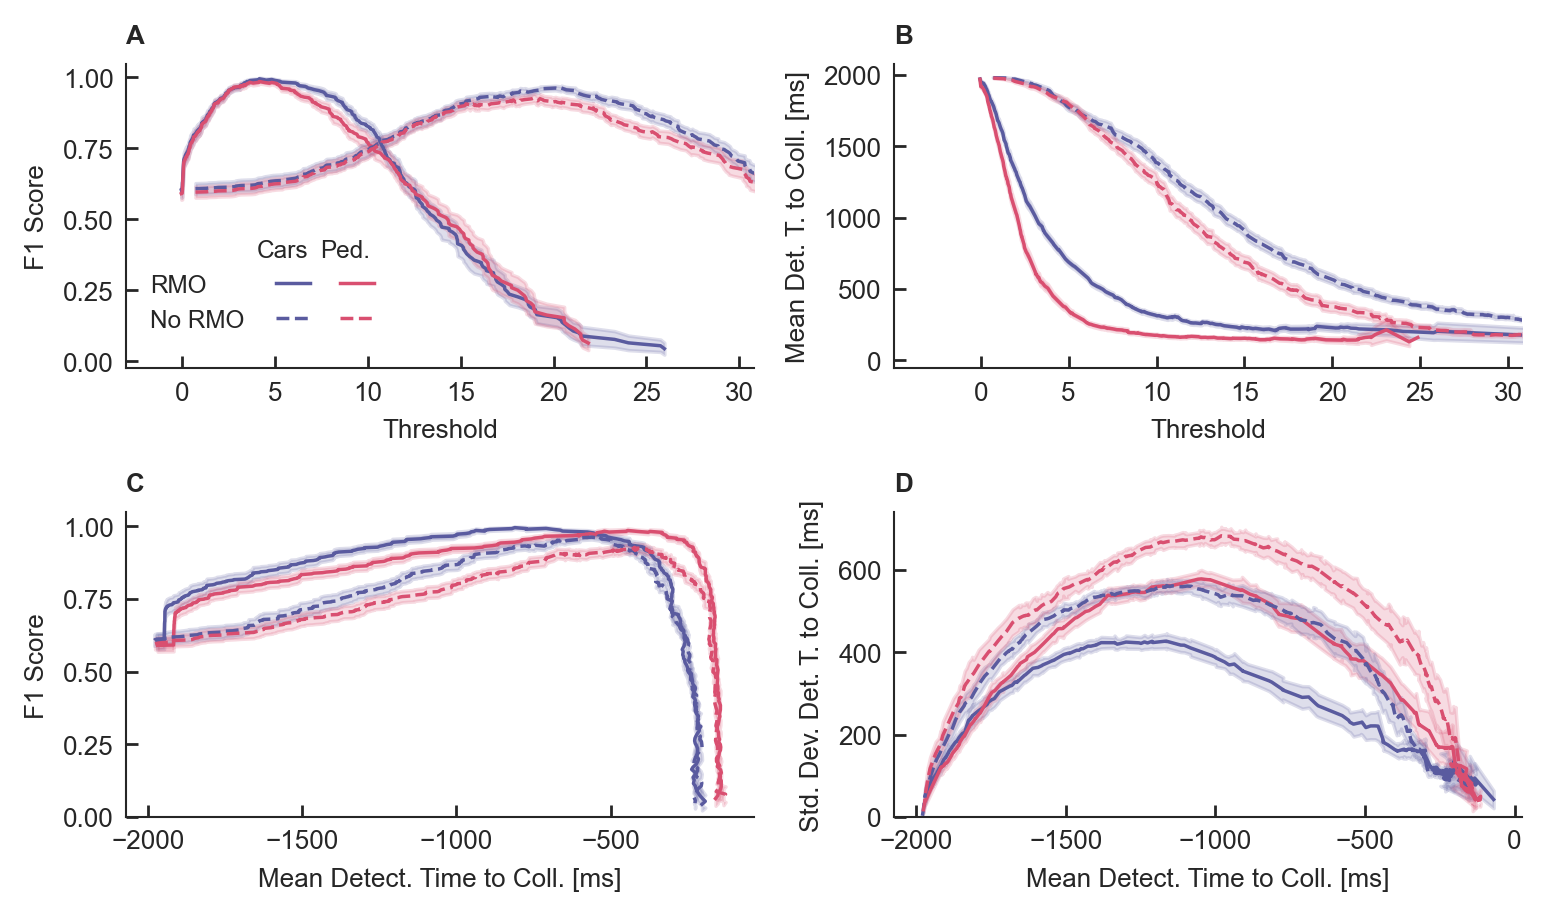

In [25]:
import matplotlib.patches as m_patches

plt.style.use('plots.mplstyle')
fig, _ax = plt.subplots(2, 2, figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.6))
ax = _ax.flatten()

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

ptch = [patches_column2, patches_column3]

for i, rmo in enumerate(["RMO", "No RMO"]):
    for j, obj in enumerate(["Cars", "Pedestrians"]):
        lnstyle = ["-", "--"][i]
        color = colors[j]

        (_line,) = ax[0].plot(th_range[rmo][obj], f1_mean[rmo][obj], lnstyle, c=color, label="*")

        ax[0].fill_between(
            th_range[rmo][obj],
            f1_mean[rmo][obj] - f1_sem[rmo][obj],
            f1_mean[rmo][obj] + f1_sem[rmo][obj],
            alpha=0.2,
            color=color,
        )      

        ax[1].plot(th_range[rmo][obj], mean_t_detect[rmo][obj], lnstyle, c=color)

        ax[1].fill_between(
            th_range[rmo][obj],
            mean_t_detect[rmo][obj] - sem_t_detect[rmo][obj],
            mean_t_detect[rmo][obj] + sem_t_detect[rmo][obj],
            alpha=0.2,
            color=color,
        )   

        ax[2].plot(-mean_t_detect[rmo][obj], f1_mean[rmo][obj], lnstyle, c=color)

        ax[2].fill_between(
            -mean_t_detect[rmo][obj],
            f1_mean[rmo][obj] - f1_sem[rmo][obj],
            f1_mean[rmo][obj] + f1_sem[rmo][obj],
            alpha=0.2,
            color=color,
        )

        ax[3].plot(-mean_t_detect[rmo][obj], std_t_detect[rmo][obj], lnstyle, c=color)

        ax[3].fill_between(
            -mean_t_detect[rmo][obj],
            std_t_detect[rmo][obj] - se_std_t_detect[rmo][obj],
            std_t_detect[rmo][obj] + se_std_t_detect[rmo][obj],
            alpha=0.2,
            color=color,
        )

        ptch[j].append(_line)


for _ax in ax[:2]: 
    _ax.set_xlim(right=30.8)
    _ax.set_xlabel("Threshold")

for _ax in ax[2:]:
    _ax.set_ylim(bottom=0.0)
    _ax.set_xlabel("Mean Detect. Time to Coll. [ms]")

for _ax in (ax[0], ax[2]):
    _ax.set_ylabel("F1 Score")

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


#ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax[0].set_ylabel("F1 Score")
ax[1].set_ylabel("Mean Det. T. to Coll. [ms]")
ax[3].set_ylabel("Std. Dev. Det. T. to Coll. [ms]")

for i, letter in enumerate(["A", "B", "C", "D"]):
    ax[i].set_title(letter, loc="left", fontweight="bold")


fig.tight_layout()

fig.savefig("f1_score_detect_time_emd.png", dpi=300)
fig.savefig("f1_score_detect_time_emd.pdf", dpi=300)

plt.show()

In [9]:
def gen_evt_hist(evts: np.ndarray, t: float, dt: float, w: int, h: int) -> np.ndarray:
    evts_filt = evts[(evts["t"] >= t) & (evts["t"] < (t + dt))]

    hist = np.histogram2d(
        evts_filt["x"],
        evts_filt["y"],
        bins=[np.arange(w + 1), np.arange(h + 1)],
        weights=evts_filt["p"].astype("i1") * 2 - 1,
    )

    img = np.minimum(1.0, np.maximum(-1.0, hist[0].T))

    return img

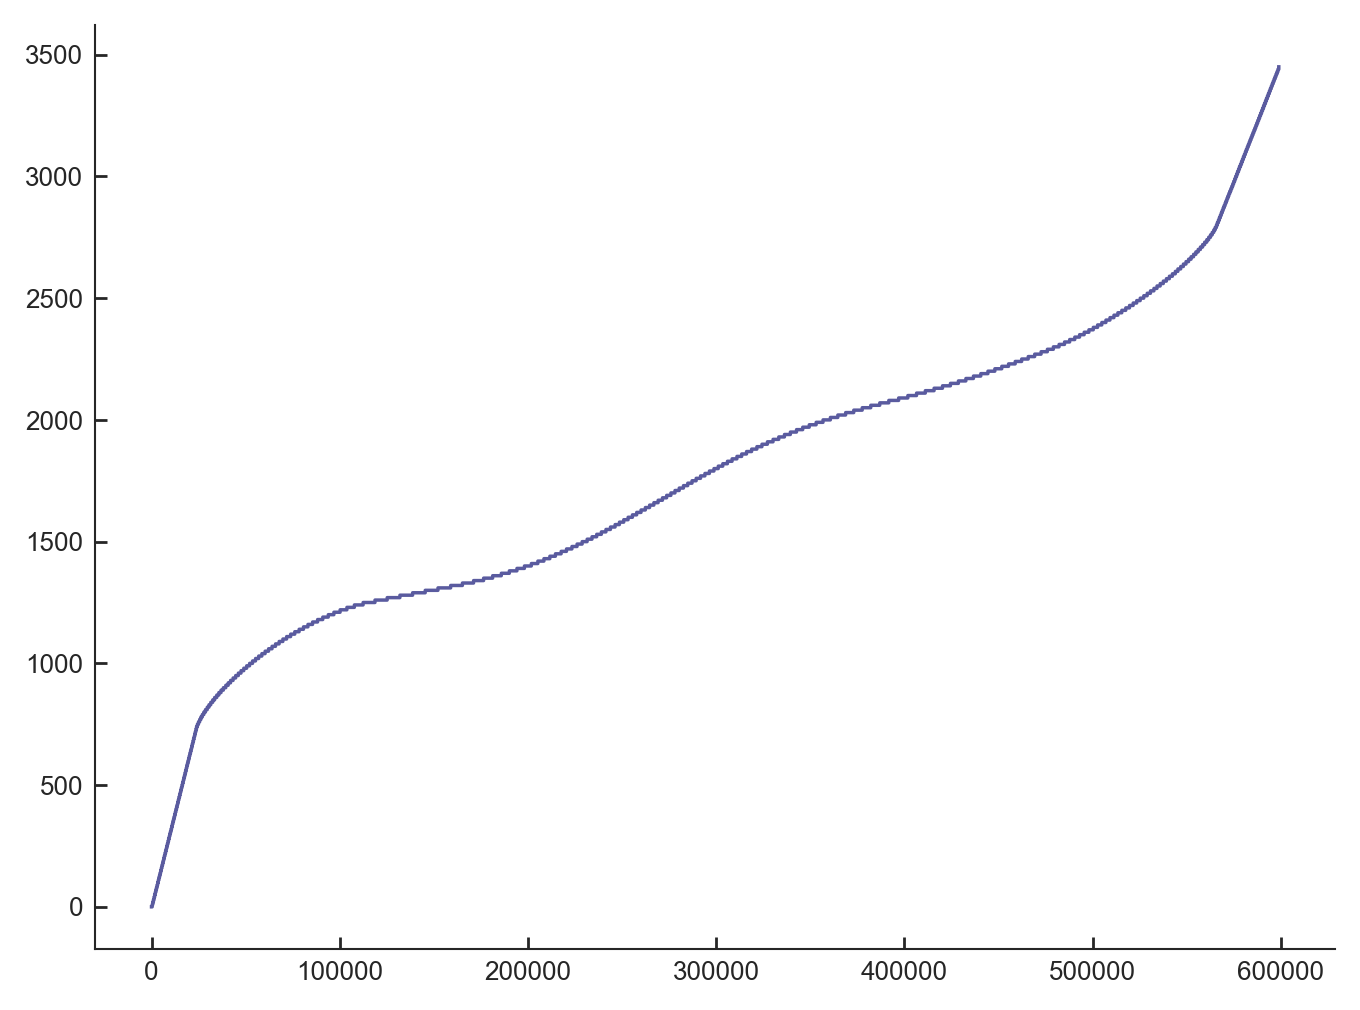

In [84]:
t_ax = data_car_passing["events"]["t"].astype(float)
t_ax += ((np.random.rand(t_ax.shape[0]) - 0.5) * 2000) * (np.cos((np.linspace(0.,1.,len(rnd))-0.5)*np.pi * 2)+1) * 0.5
t_ax = np.clip(t_ax, 0, 3450)
t_ax = np.sort(t_ax)

rnd = np.random.rand(t_ax.shape[0])
ftrnd = np.fft.fft(rnd)
ftrnd[3:] = 0
ftrnd[0] = 0
rnd = np.fft.ifft(ftrnd).real * 90000
rnd *= (np.cos((np.linspace(0.,1.,len(rnd))-0.5)*np.pi * 2)+1) * 0.5

t_ax = ((t_ax + rnd) / 10).astype(np.uint32) * 10

data_car_passing["events"]["t"] = t_ax

np.savez(os.path.join(sim_manual_rec_fold, "recorded_live_demo_car_passing.npz"), events=data_car_passing["events"], r_left=data_car_passing["r_left"], r_right=data_car_passing["r_right"], V=data_car_passing["V"])

plt.plot(t_ax)
plt.show()

In [93]:
data_car_passing = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_car_passing.npz"))

idx_start_passing = 100
idx_end = 250

V_passing = data_car_passing["V"][idx_start_passing:idx_end]
r_left_passing = data_car_passing["r_left"][idx_start_passing:idx_end]
r_right_passing = data_car_passing["r_right"][idx_start_passing:idx_end]
V_linear_passing = (r_left_passing + r_right_passing)

t_ms_passing = np.arange(0, len(V_passing)) * 10.0

events_passing = data_car_passing["events"]

data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start_turn = 75
idx_end = -1

V_turn = data_right_turn["V"][idx_start_turn:idx_end]
r_left_turn = data_right_turn["r_left"][idx_start_turn:idx_end]
r_right_turn = data_right_turn["r_right"][idx_start_turn:idx_end]
V_linear_turn = (r_left_turn + r_right_turn)

t_ms_turn = np.arange(0, len(V_turn)) * 10.0

events_turn = data_right_turn["events"]

1551


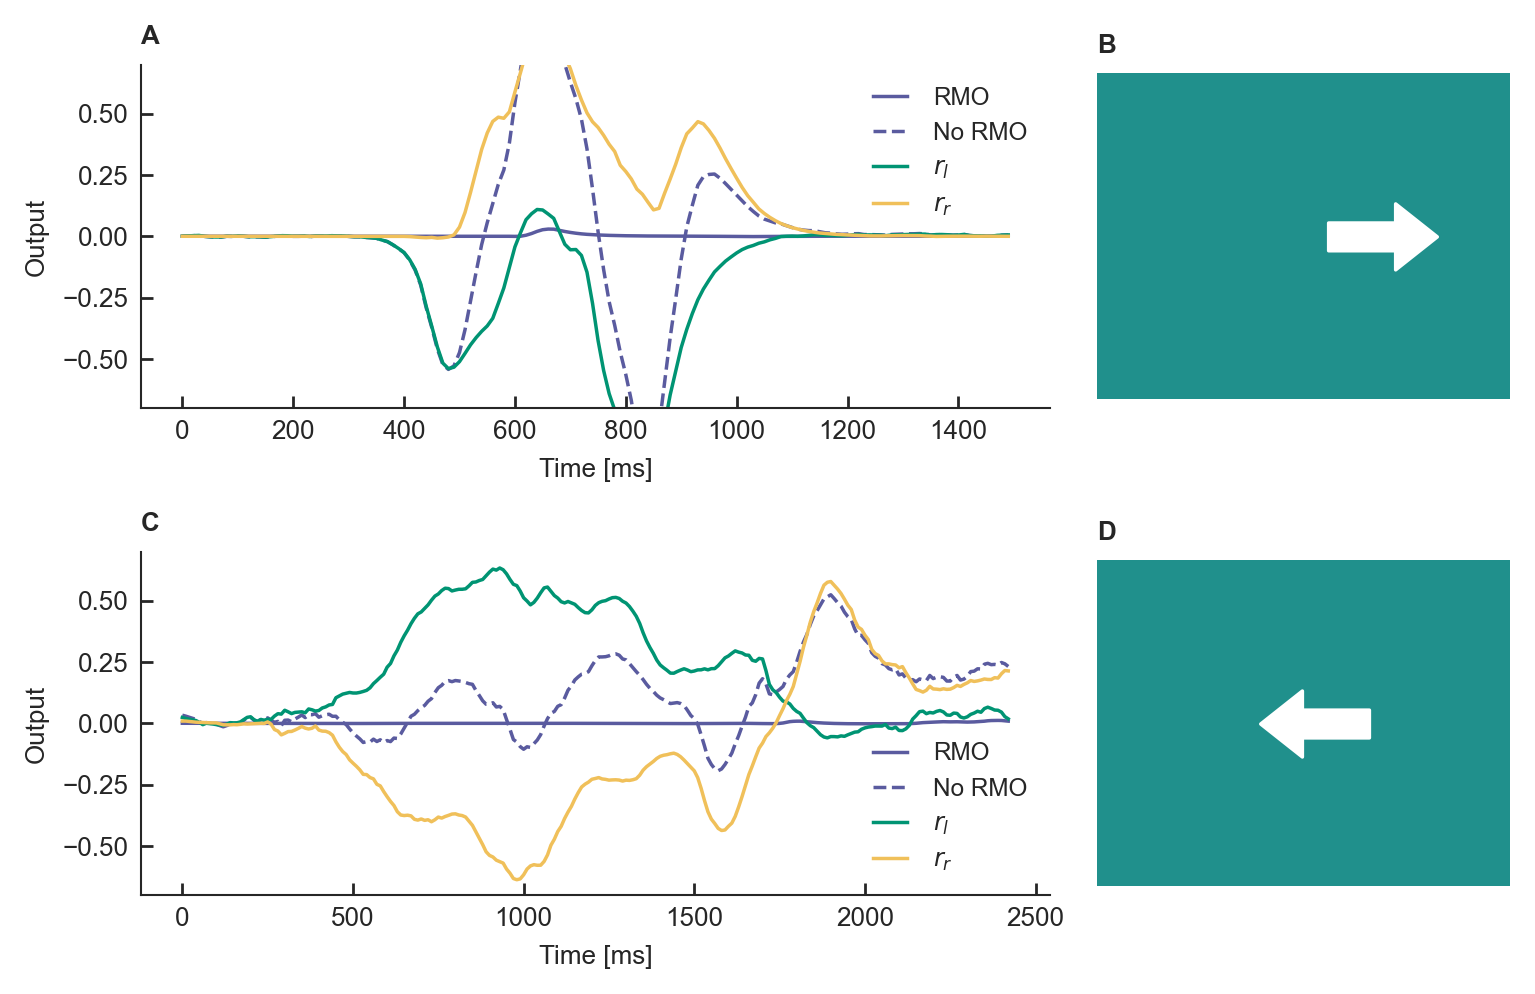

In [90]:
from matplotlib.colors import ListedColormap

#cmap_evts = ListedColormap([(1,0,0), "black", (0,1,0)])
cmap_evts = "viridis"

plt.style.use('plots.mplstyle')

fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.65))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

#w_l = 0.64
#w_r = 0.4
#m_l = 0.065
#m_r = 0.66
#m_b = 0.08
#m_t = 0.5 + m_b - 0.025
#h = 0.5 - m_b - 0.025
gs = fig.add_gridspec(2, 2, width_ratios=[2.2, 1], height_ratios=[1, 1])

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1]))


#fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].plot(t_ms_passing, V_passing, label="RMO", color=colors[0])
ax[0].plot(t_ms_passing, V_linear_passing, '--', label="No RMO", color=colors[0])
ax[0].plot(t_ms_passing, r_left_passing, label="$r_l$", color=colors[2])
ax[0].plot(t_ms_passing, r_right_passing, label="$r_r$", color=colors[3])

ax[0].legend()

ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Output")

ax[0].set_ylim(-0.7, 0.7)

print(events_passing[180000]["t"])

img = gen_evt_hist(events_passing, 500 + 10*idx_start_passing, 20., 304, 240)

ax[1].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[1].grid(False)

ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].annotate(None,xy=(250,120),xytext=(170,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

ax[2].plot(t_ms_turn, V_turn, label="RMO", color=colors[0])
ax[2].plot(t_ms_turn, V_linear_turn, '--', label="No RMO", color=colors[0])
ax[2].plot(t_ms_turn, r_left_turn, label="$r_l$", color=colors[2])
ax[2].plot(t_ms_turn, r_right_turn, label="$r_r$", color=colors[3])

ax[2].legend()

ax[2].set_xlabel("Time [ms]")
ax[2].set_ylabel("Output")

ax[2].set_ylim(-0.7, 0.7)

img = gen_evt_hist(events_turn[180000:190000],  1000 + 10*idx_start_turn, 20., 304, 240)

ax[3].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[3].grid(False)

ax[3].spines["left"].set_visible(False)
ax[3].spines["bottom"].set_visible(False)

ax[3].set_xticks([])
ax[3].set_yticks([])

ax[3].annotate(None,xy=(120,120),xytext=(200,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

for i, c in enumerate("ABCD"):
    ax[i].set_title(c, loc="left", fontweight="bold")

fig.tight_layout()

#fig.tight_layout(pad=0.25)

fig.savefig("car_passing_turn.png", dpi=300)
fig.savefig("car_passing_turn.pdf", dpi=300)

plt.show()

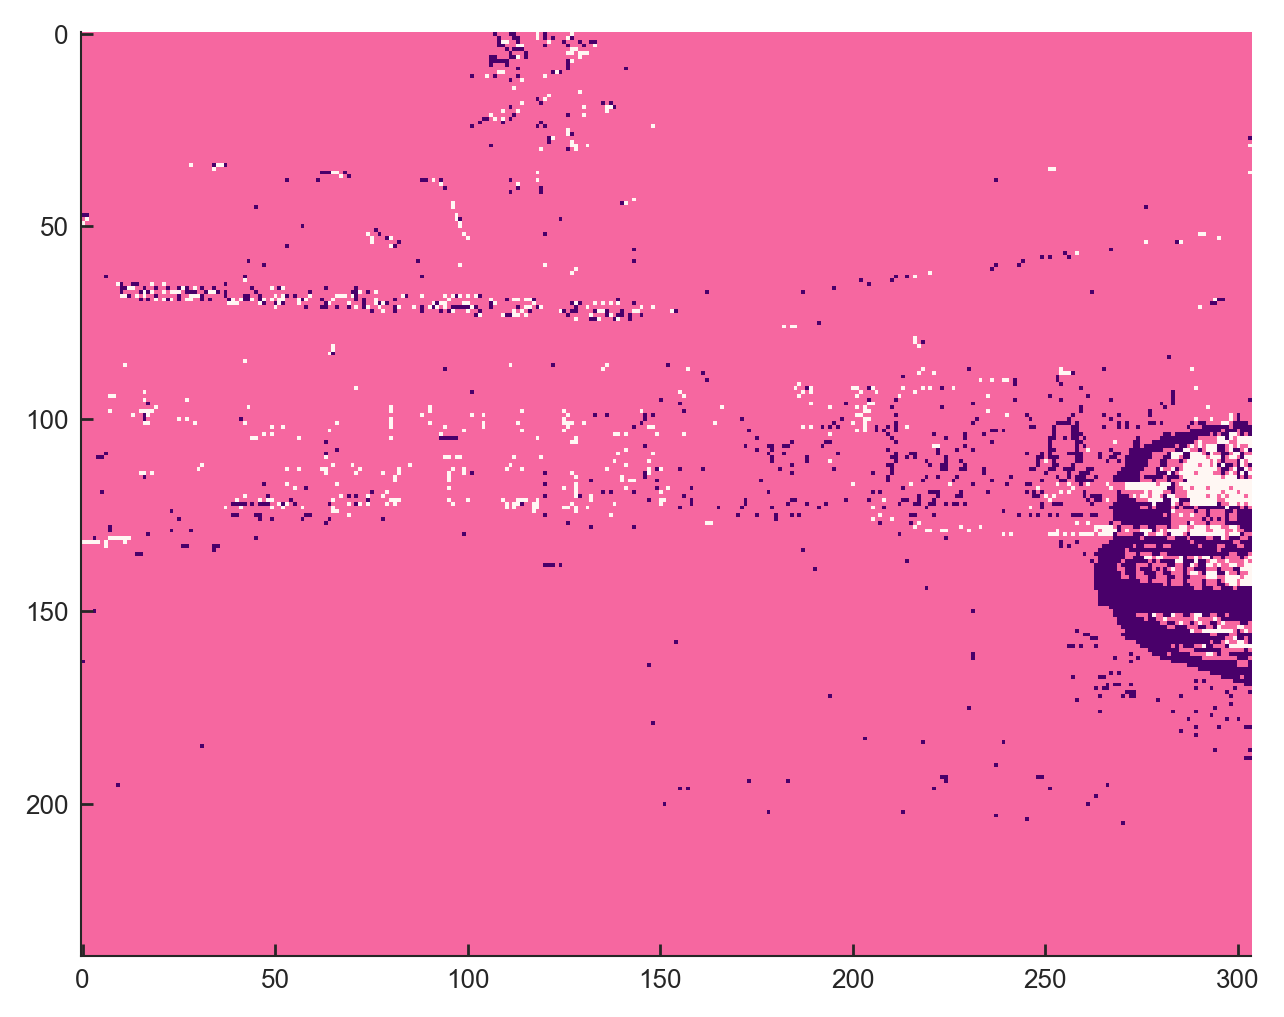

In [44]:
k = 540000

plt.imshow(gen_evt_hist(events_passing[k:k+10000], 0., 20., 304, 240))
plt.show()

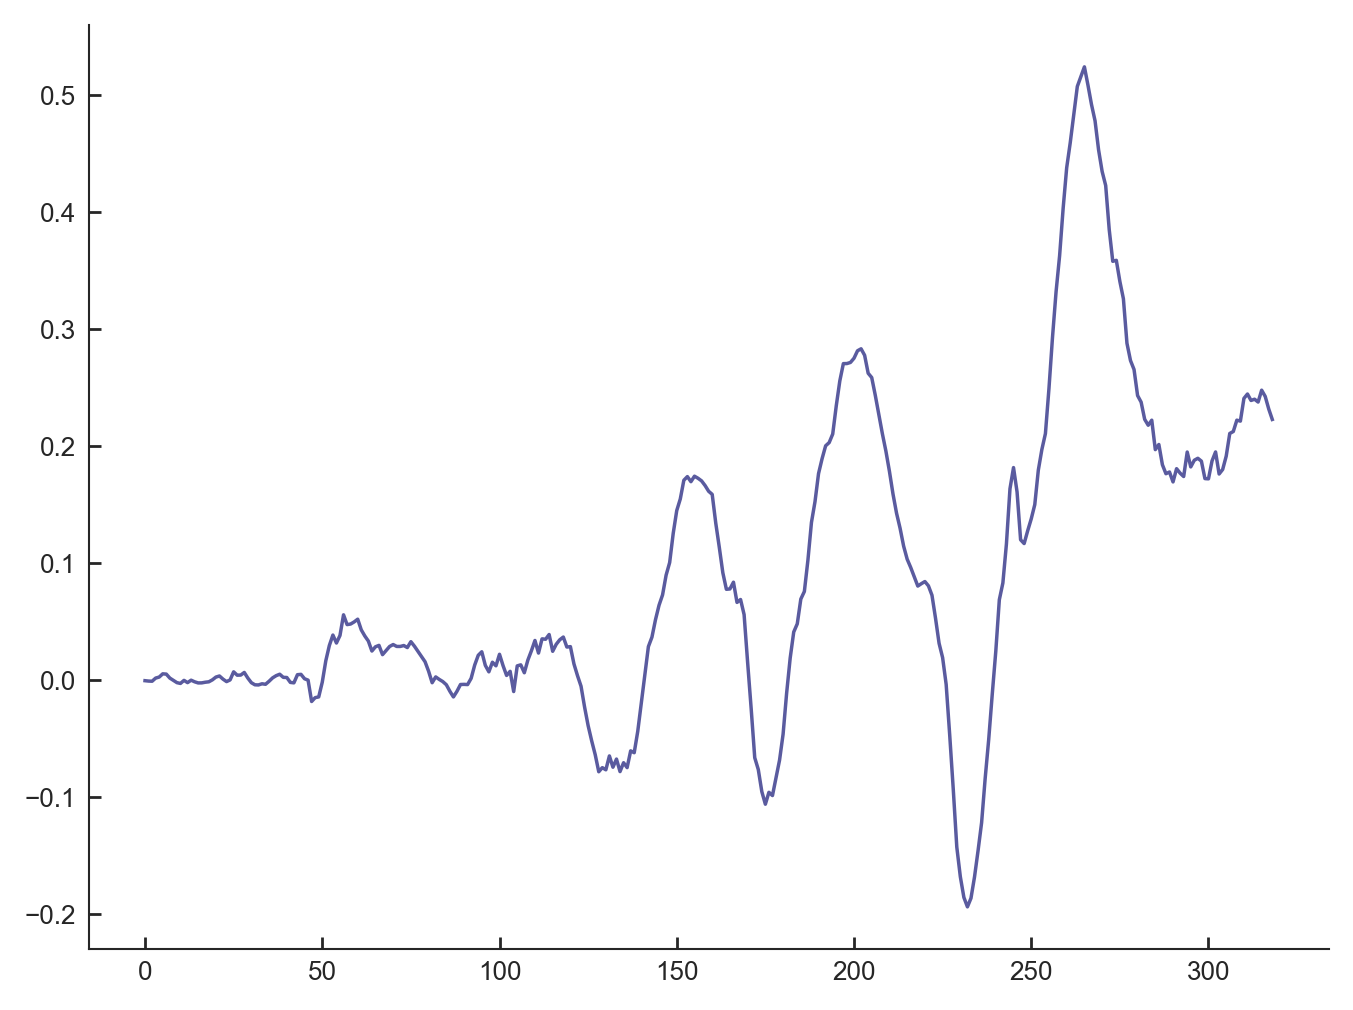

In [45]:
plt.plot(data_right_turn["r_left"]+data_right_turn["r_right"])
plt.show()

In [46]:
data_right_turn["V"].shape

(319,)

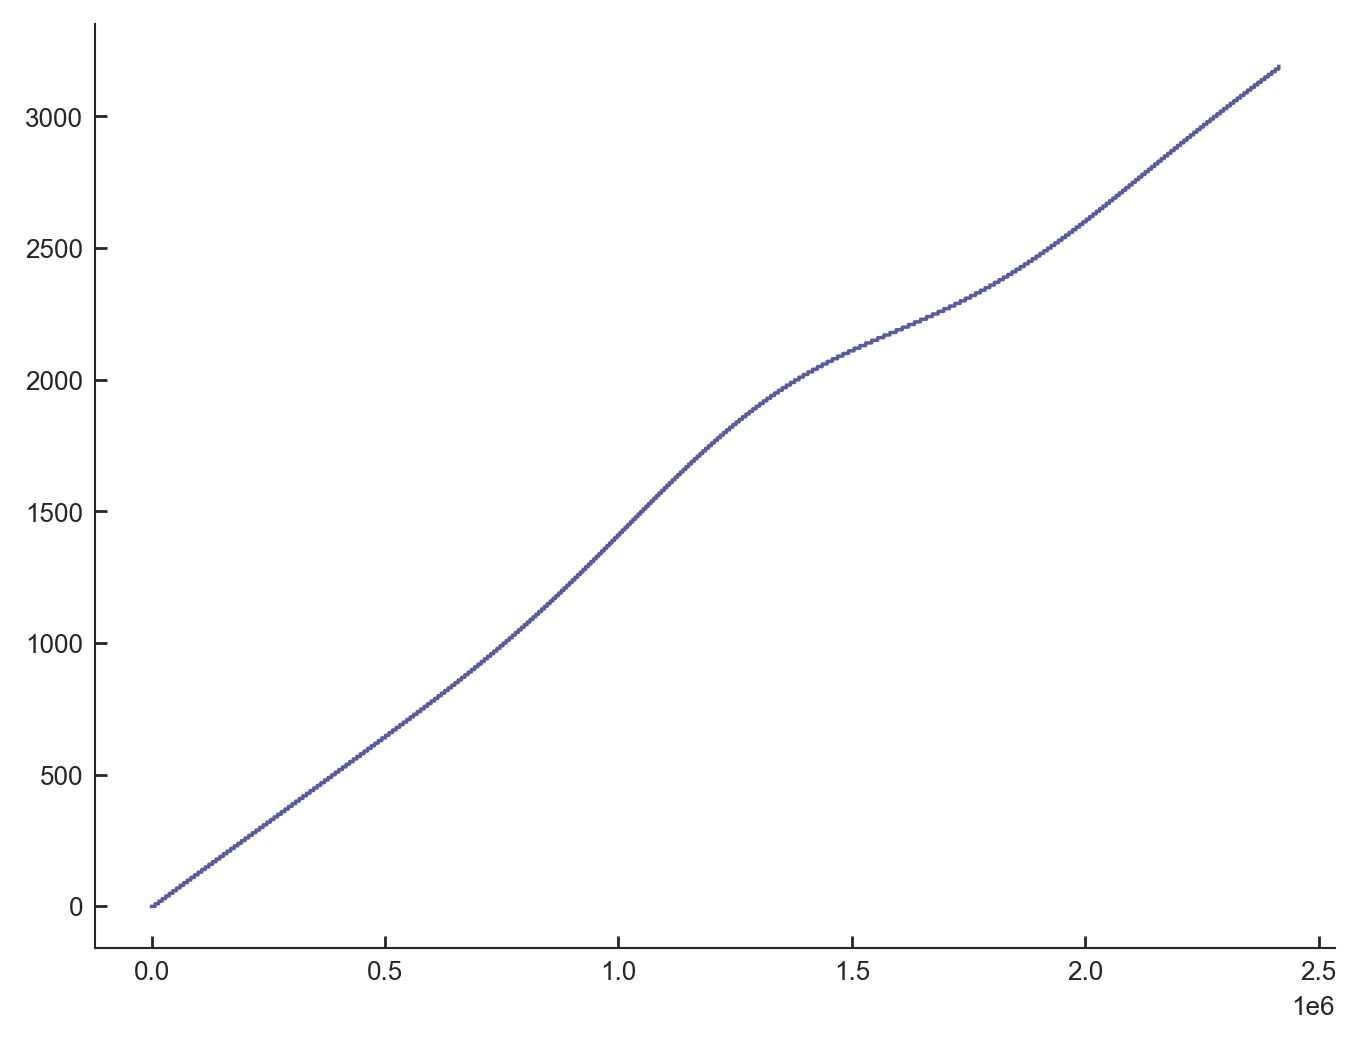

In [ ]:

rnd = np.random.rand(len(data_right_turn["events"]))
ftrnd = np.fft.fft(rnd)
ftrnd[3:] = 0
ftrnd[0] = 0
rnd = np.fft.ifft(ftrnd).real * 900000
rnd *= (np.cos((np.linspace(0.,1.,len(rnd))-0.5)*np.pi * 2)+1) * 0.5

t_ax = ((np.linspace(0, 3190, len(rnd)) + rnd) / 10).astype(int) * 10

plt.plot(t_ax)
plt.show()

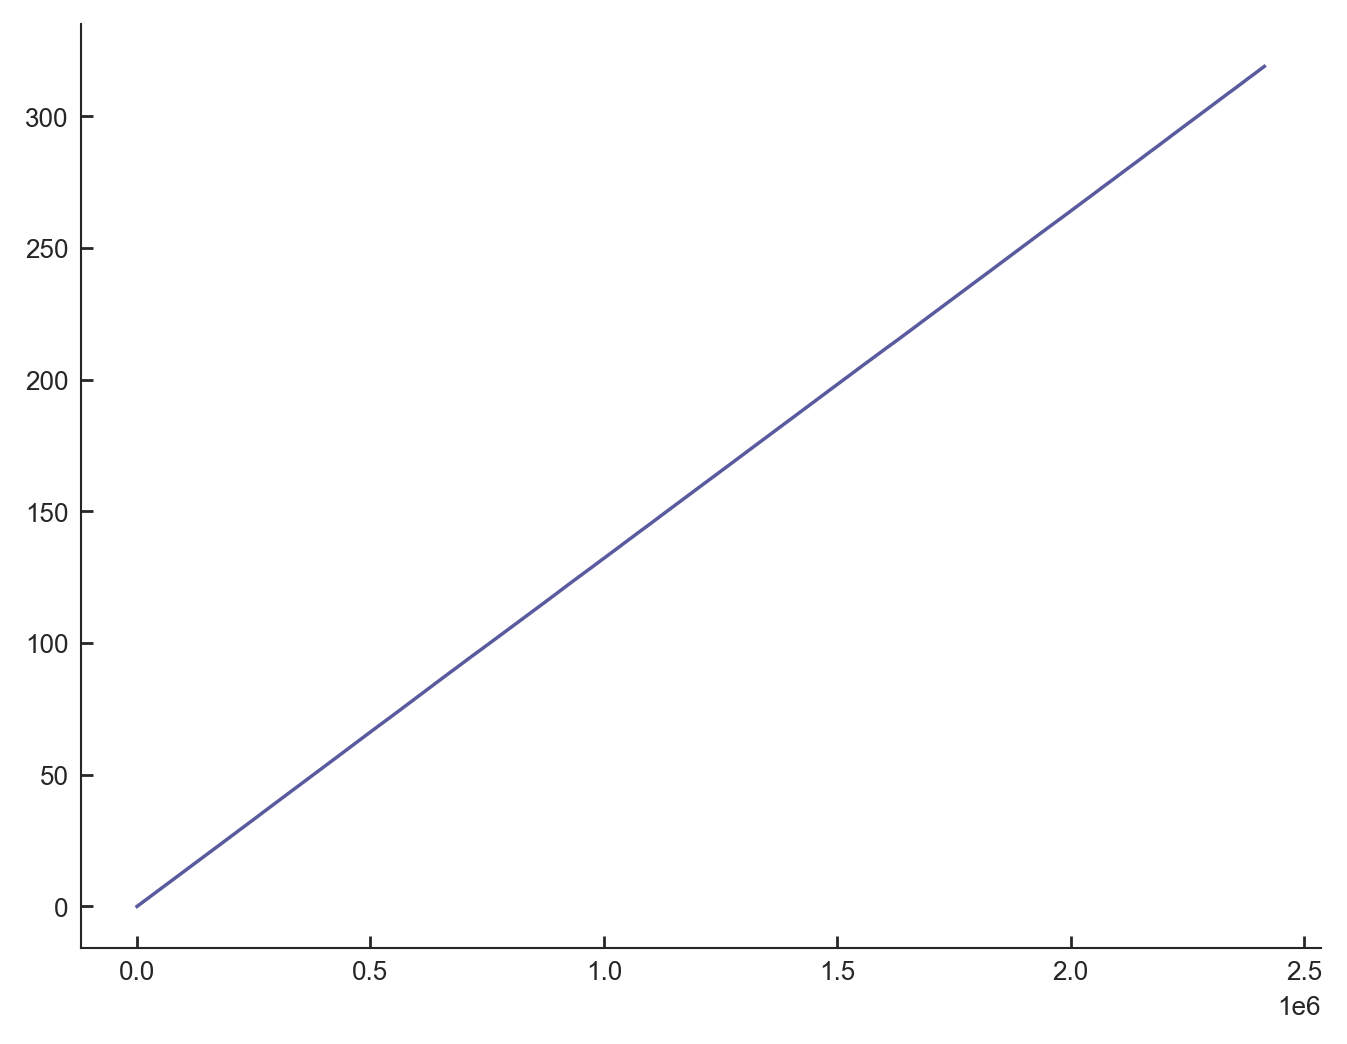

In [48]:
t_ax=np.random.rand(len(data_right_turn["events"])) * len(data_right_turn["V"])
t_ax = np.sort(t_ax)

plt.plot(t_ax)
plt.show()

In [50]:
events_example = np.load("../../../data/carla_sim/random_spawn/example_0/events.npy")

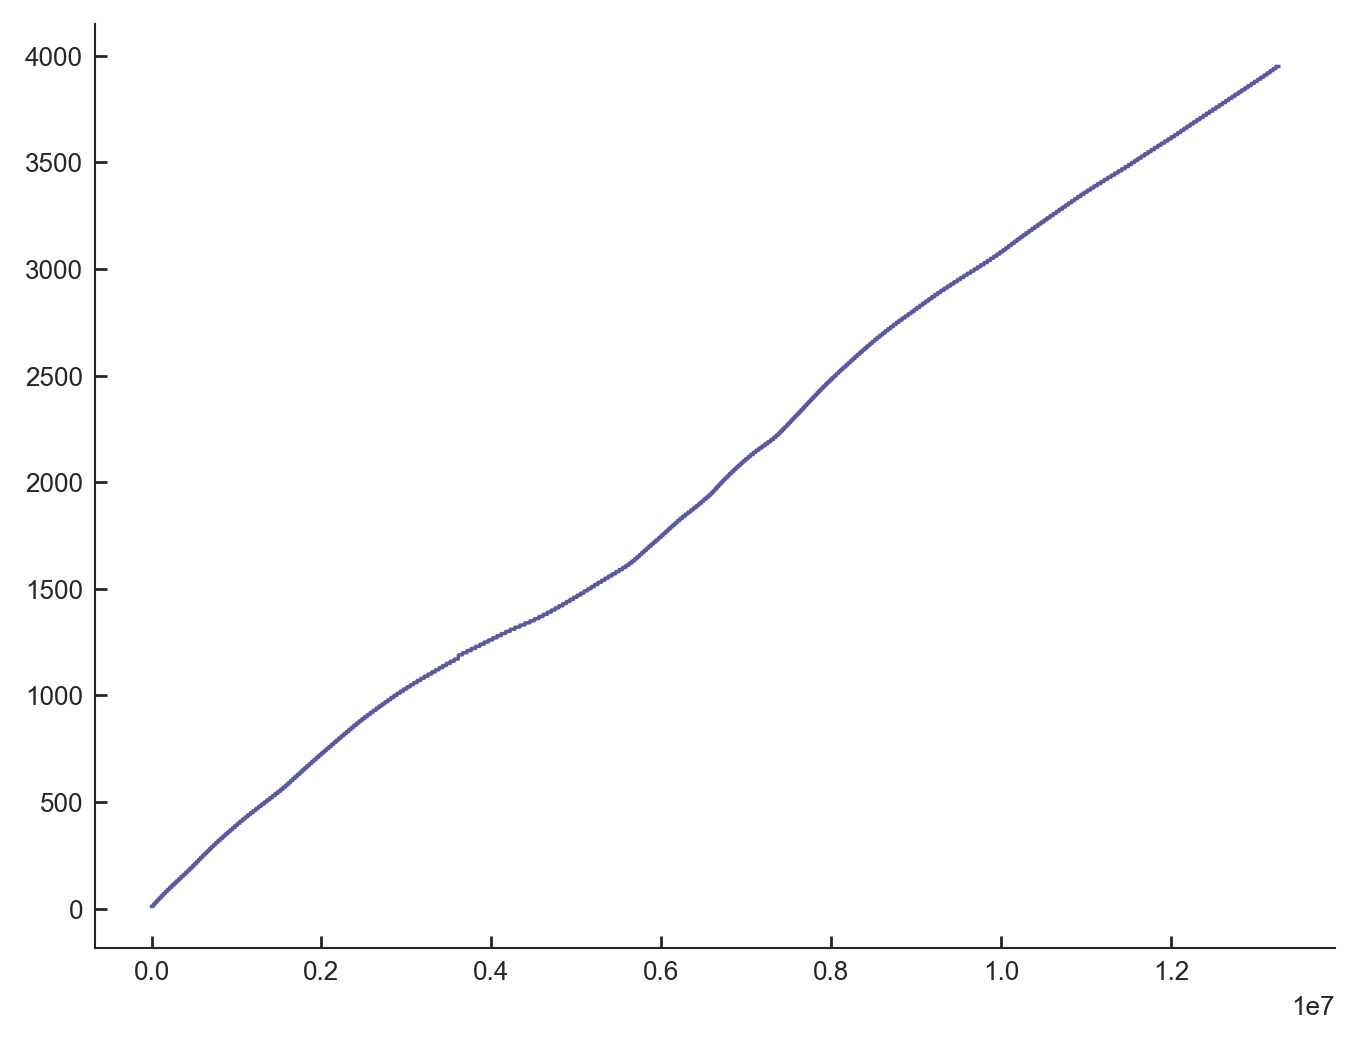

In [53]:
plt.plot(events_example["t"])
plt.show()

In [41]:
data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start = 75
idx_end = -1

V = data_right_turn["V"][idx_start:idx_end]
r_left = data_right_turn["r_left"][idx_start:idx_end]
r_right = data_right_turn["r_right"][idx_start:idx_end]
V_linear = 0.5 * (r_left + r_right)

t_ms = np.arange(0, len(V)) * 10.0

events = data_right_turn["events"]